<a href="https://colab.research.google.com/github/Nytilde/Edda/blob/master/MLDifficultyPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import json
import os
import csv
import random
import seaborn as sns
import scipy.stats as stats
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVR, SVC
from collections import Counter

In [ ]:
def getMapDataForPath(path):
    mapDataName = ""
    if "info.dat" in os.listdir(f"{path}"):
        mapDataName = "info.dat"
    if "Info.dat" in os.listdir(f"{path}"):
        mapDataName = "Info.dat"
    with open(f"{path}/{mapDataName}", "r") as f:
        mapData = f.read()
        mapJson = json.loads(mapData)
        return mapJson

def getMapData(mapFolder, folder):
    return getMapDataForPath(f"{mapFolder}/{folder}")

def getDifficultyMapsForPath(path):
    difficultyMaps = []
    mapJson = getMapDataForPath(path)
    for d in mapJson["_difficultyBeatmapSets"][0]["_difficultyBeatmaps"]:
        difficultyMaps.append((d["_beatmapFilename"], d["_difficultyRank"]))
    return difficultyMaps

def getDifficultyMaps(mapFolder, folder):
    return getDifficultyMapsForPath(f"{mapFolder}/{folder}")

def getDifficultyMapDataForPath(path, file):
    filePath = f"{path}/{file}"
    with open(filePath, "r") as f:
        mapData = f.read()
        mapJson = json.loads(mapData)
        return mapJson

def getDifficultyMapData(mapFolder, folder, file):
    return getDifficultyMapDataForPath(f"{mapFolder}/{folder}", file)

def getMaps(mapFolder):
    maps = []
    for obj in os.listdir(f"{mapFolder}"):
        objPath = f"{mapFolder}/{obj}"
        if os.path.isdir(objPath) and ("info.dat" in os.listdir(objPath) or "Info.dat" in os.listdir(objPath)):
            maps.append(obj)
    return maps

def beatToSec(beat, bpm):
    return 60/bpm * beat

# def getNoteDensity(diffMapData, duration):
#     notesList = diffMapData["_notes"]
#     return len(notesList)/duration

# # heuristically, windowLength = 2.75, step = 0.25 is best  // replaced by numpy version
# def getLocalNoteDensities(time_array, duration, windowLength=2.75, step=0.25):
#     densities = []
#     windowLower = 0
#     windowUpper = windowLength
#     while windowUpper < duration:
#         numNotes = 0
#         for noteTime in time_array:
#             if windowLower <= noteTime and noteTime <= windowUpper:
#                 numNotes += 1
#         densities.append(numNotes/windowLength)
#         windowLower += step
#         windowUpper += step
#     return densities

# def getLocalColumnVariety(diffMapData, duration, bpm, windowLength=2.75, step=0.25):
#     variety = []
#     beatsPerWindow = bpm/60 * windowLength
#     windowLower = 0
#     windowUpper = windowLength
#     while windowUpper < duration:
#         localVariety = np.array([0, 0, 0, 0])
#         for n in diffMapData["_notes"]:
#             noteTime = beatToSec(n["_time"], bpm)
#             noteCol = n["_lineIndex"]
#             if windowUpper <= noteTime:
#                 break
#             if windowLower <= noteTime:
#                 localVariety[noteCol] += 1
#             if np.linalg.norm(localVariety, 1) > 0:
#                 # L1-normalise or normalise for the amount of notes
#                 normLocalVariety = localVariety / np.linalg.norm(localVariety, 1)
#                 # maps with higher column variety will have a distribution closer to [.25, .25, .25, .25]
#                 score = np.linalg.norm(normLocalVariety - np.array([0.25, 0.25, 0.25, 0.25]), 2)
#                 # higher is better
#                 variety.append(-1 * score)

#         windowLower += step
#         windowUpper += step
#     return variety

In [ ]:
# use numpy and vectorized processing instead of loop
def get_note_density_per_window(time_array, time_diff, window_length=2.75):
    cumulative_time = np.cumsum(time_diff)

    start_times = time_array - window_length

    start_indices = np.searchsorted(cumulative_time, start_times, side='left')
    end_indices = np.searchsorted(cumulative_time, time_array, side='left')

    return (end_indices - start_indices) / window_length

def get_note_density(float_array, duration):
    return len(float_array)/duration

def extract_times_from_dicts_list(dicts_list, bpm, key='_time'):
    return np.array([beatToSec(d['_time'], bpm) for d in dicts_list])

def get_min_max_diff(float_array):
    return max(float_array) - min(float_array)

def remove_zeros(float_array, tolerance=1e-4):
    non_zero_indices = np.abs(float_array) > tolerance
    return float_array[non_zero_indices]

def get_longest_low_value_sequence(time_diffs):
    unique_values, indices, counts = np.unique(time_diffs, return_index=True, return_counts=True)
    matrix = np.zeros((len(unique_values), len(time_diffs)), dtype=int)

    for idx, count in zip(indices, counts):
        val_index = np.where(unique_values == time_diffs[idx])[0][0]
        matrix[val_index, idx:idx+count] = 1

    row_sums = np.sum(matrix, axis=1)
    max_density_index = np.argmax(row_sums / len(time_diffs))
    max_density = row_sums[max_density_index] / len(time_diffs)

    series_start = np.argmax(matrix[max_density_index])
    series_end = np.argmax(np.flip(matrix[max_density_index]))

    return time_diffs[series_start:series_end+1]

def generate_leave_one_value_out_sequence(lst):
    for i, value in enumerate(lst):
         yield (lst[:i] + lst[i+1:], value)

def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data)))

def max_abs_column_name(row):
    return row.abs().idxmax()

def min_abs_column_name(row):
    return row.abs().idxmin()

def second_max_abs_column_name(row):
    return row.abs().sort_values(ascending=False).index[1]

def plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap=cmap)

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)

    plt.show()

# Upload / Import Raw Data

In [ ]:
import zipfile

def unzip_file(path, extract_to):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    extracted_files = os.listdir(extract_to)

unzip_file("RagnarockMaps.zip",'./')

In [ ]:
# Google Drive
MAP_FOLDER = '/content/drive/My Drive/ragna/RagnarockMaps'

In [ ]:
# uploaded
MAP_FOLDER = '/RagnarockMaps/RagnarockMaps'

In [ ]:
for root, dirs, files in os.walk(MAP_FOLDER):
    for file in files:
        file_path = os.path.join(root, file)
        print(file_path)

# Data Preparations

In [ ]:
# TODO:

# ✓ rework of get_max_time() to determine the range between first and last time instead

# ✓ Calculate vector of time difference Δt (change rate)
#   ✓ the average time difference
#   ✓ longest break (maybe linear dependency)
#   ✓ double notes (change rate = 0)
#   ✓ longest low time periode
#   ✓ inspect quantil range
#   - amount of breaks within a time window
#   - any ideas?

# ✓ NoteDensity Δt > 1 range
#   - inspect quantil range
#   - inspect window size

# - Find and count "hard to play patterns":
#   - define and match pattern by using a frequence (e.g. 1, 2, 3, 4, 3, 2, 1)
#   - always check if it is a double note (if time is equal)
#   - define a weight to each pattern
#   - add a threshold value for the time difference between each note within the pattern
#   - count each weight
#   (if there is no use here, maybe we can add this also to EDDA)

def transform_data(target_feature):
    for beatmap in getMaps(MAP_FOLDER):
        mapData = getMapData(MAP_FOLDER, beatmap)
        songName = mapData["_songName"]
        songDuration = mapData["_songApproximativeDuration"]
        songBpm = mapData["_beatsPerMinute"]

        diffMaps = getDifficultyMaps(MAP_FOLDER, beatmap)
        for diffMapObj in diffMaps:
            diffMap = diffMapObj[0]
            diffRank = diffMapObj[1]

            # don't train on maps with >10 rank
            if (diffRank > 10):
                print(f"diff rank > 10 excluded: '{songName}'")
                continue

            diffMapData = getDifficultyMapData(MAP_FOLDER, beatmap, diffMap)

            time_series = extract_times_from_dicts_list(diffMapData['_notes'], songBpm, key='_time')
            time_differences = np.diff(time_series)
            time_differences_no_zero = remove_zeros(time_differences)
            max_time = get_min_max_diff(time_series)

            diffMapNoteDensity = get_note_density(time_series, max_time)

            # diffMapLND2s = getLocalNoteDensities(diffMapData, max_time, songBpm, windowLength=2.75)
            diffMapLND2s = get_note_density_per_window(time_series, time_differences_no_zero, window_length=2.75)
            maxND2s = np.quantile(diffMapLND2s, 0.95)
            diffMapLND8s = get_note_density_per_window(time_series, time_differences_no_zero, window_length=8)

            average_time_diff = np.mean(time_differences_no_zero)
            longest_break = max(time_differences)
            double_notes = np.sum(time_differences == 0)


            longest_high_density_sequence = get_longest_low_value_sequence(time_differences_no_zero)

            auc = np.trapz(time_series, range(len(time_series)))

            average_2s_density = np.mean(diffMapLND2s)
            average_8s_density = np.mean(diffMapLND8s)

            yield {
                "SongName": songName,
                "BPM": songBpm,
                "NoteDensity": diffMapNoteDensity,
                "HighNoteDensity2s": maxND2s,
                "AverageTimeDifference": average_time_diff,
                "LongestBreak": longest_break,
                "DoubleNotes": double_notes,
                "LongestHighDensitySequence": longest_high_density_sequence,
                "auc": auc,
                "TimeDifferences": time_differences_no_zero,
                "Notes": time_series,
                "DiffMapLND2s": diffMapLND2s,
                "diffMapLND8s": diffMapLND8s,
                "Average2sDensity": average_2s_density,
                "Average8sDensity": average_8s_density,
                target_feature: diffRank
            }

targetFeature = ["Difficulty"]

df = pd.DataFrame(transform_data(targetFeature[0]))

In [ ]:
# change rate
for i in range(9):
  j = (i+1)/10
  df[f"d1Q{j}"] = df["TimeDifferences"].apply(lambda x: np.quantile(x, j))
  df[f"d8Q{j}"] = df["diffMapLND8s"].apply(lambda x: np.quantile(x, j))
  df[f"d2.75Q{j}"] = df["DiffMapLND2s"].apply(lambda x: np.quantile(x, j))
df["d1Q0.1"]

0      0.234375
1      0.117188
2      0.117188
3      0.238095
4      0.119048
         ...   
235    0.236220
236    0.118110
237    0.375000
238    0.187500
239    0.093750
Name: d1Q0.1, Length: 240, dtype: float64

In [ ]:
df["d1max"] = df["TimeDifferences"].apply(lambda x: np.max(x))
df["d8max"] = df["diffMapLND8s"].apply(lambda x: np.max(x))
df["d2.75max"] = df["DiffMapLND2s"].apply(lambda x: np.max(x))

df["d1min"] = df["TimeDifferences"].apply(lambda x: np.min(remove_zeros(x)))
df["d8min"] = df["diffMapLND8s"].apply(lambda x: np.min(remove_zeros(x)))
df["d2.75min"] = df["DiffMapLND2s"].apply(lambda x: np.min(remove_zeros(x)))

df["d1mad"] = df["TimeDifferences"].apply(lambda x: mean_absolute_deviation(x))
df["d8mad"] = df["diffMapLND8s"].apply(lambda x: mean_absolute_deviation(x))
df["d2.75mad"] = df["DiffMapLND2s"].apply(lambda x: mean_absolute_deviation(x))

df["d1std"] = df["TimeDifferences"].apply(lambda x: np.std(x))
df["d8std"] = df["diffMapLND8s"].apply(lambda x: np.std(x))
df["d2.75std"] = df["DiffMapLND2s"].apply(lambda x: np.std(x))

df["d8mean"] = df["diffMapLND8s"].apply(lambda x: np.mean(x))
df["d2.75mean"] = df["DiffMapLND2s"].apply(lambda x: np.mean(x))

df["LongestHighDensitySequenceLen"] = df["LongestHighDensitySequence"].apply(lambda x: len(x))
df["LongestHighDensitySequenceAverage"] = df["LongestHighDensitySequence"].apply(lambda x: np.average(x)).fillna(0.0)


df["ammountNotes"] = df["Notes"].apply(lambda x: len(x))
df["aucRel"] = df.apply(lambda row: row["auc"] / row["ammountNotes"], axis=1)
df["BPMxN"] = df.apply(lambda row: (row["ammountNotes"] - row["DoubleNotes"]) * row["BPM"], axis=1)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


In [ ]:
def exclude_elements(input_list, excluded_elements):
    return [x for x in input_list if x not in set(excluded_elements)]

featureList = exclude_elements(df.columns.to_list(), [*targetFeature, "TimeDifferences", "Notes", "DiffMapLND2s", "diffMapLND8s", 'SongName', 'LongestHighDensitySequence'])
print(featureList)
print(len(featureList))

['BPM', 'NoteDensity', 'HighNoteDensity2s', 'AverageTimeDifference', 'LongestBreak', 'DoubleNotes', 'auc', 'Average2sDensity', 'Average8sDensity', 'd1Q0.1', 'd8Q0.1', 'd2.75Q0.1', 'd1Q0.2', 'd8Q0.2', 'd2.75Q0.2', 'd1Q0.3', 'd8Q0.3', 'd2.75Q0.3', 'd1Q0.4', 'd8Q0.4', 'd2.75Q0.4', 'd1Q0.5', 'd8Q0.5', 'd2.75Q0.5', 'd1Q0.6', 'd8Q0.6', 'd2.75Q0.6', 'd1Q0.7', 'd8Q0.7', 'd2.75Q0.7', 'd1Q0.8', 'd8Q0.8', 'd2.75Q0.8', 'd1Q0.9', 'd8Q0.9', 'd2.75Q0.9', 'd1max', 'd8max', 'd2.75max', 'd1min', 'd8min', 'd2.75min', 'd1mad', 'd8mad', 'd2.75mad', 'd1std', 'd8std', 'd2.75std', 'd8mean', 'd2.75mean', 'LongestHighDensitySequenceLen', 'LongestHighDensitySequenceAverage', 'ammountNotes', 'aucRel', 'BPMxN']
55


In [ ]:
X = df[featureList]
y = df[targetFeature]

# Visualization

## descriptive

In [ ]:
df.describe()

BPM  NoteDensity  HighNoteDensity2s  AverageTimeDifference  \
count  240.000000   240.000000         240.000000             240.000000   
mean   150.812500     4.378120           5.805833               0.312750   
std     32.550608     1.297783           2.114966               0.119412   
min     60.000000     1.627074           2.181818               0.152743   
25%    128.000000     3.286362           4.195455               0.222472   
50%    149.000000     4.270664           5.636364               0.287035   
75%    174.250000     5.360652           7.272727               0.387574   
max    244.000000     7.615101          12.363636               0.793388   

       LongestBreak  DoubleNotes           auc  Average2sDensity  \
count    240.000000   240.000000  2.400000e+02        240.000000   
mean       3.688310   166.729167  1.307730e+05          3.873541   
std        3.236181    88.172411  1.179285e+05          1.322264   
min        0.625000     1.000000  1.078299e+04          1.348351   
25%        1.736779   101.750000  6.899945e+04          2.820145   
50%        2.700000   154.000000  1.040520e+05          3.820998   
75%        4.285714   214.250000  1.507973e+05          4.897766   
max       23.435432   579.000000  1.162695e+06          7.128545   

       Average8sDensity  Difficulty  ...    d2.75std      d8mean   d2.75mean  \
count        240.000000  240.000000  ...  240.000000  240.000000  240.000000   
mean           3.773041    5.562500  ...    1.214697    3.773041    3.873541   
std            1.264198    2.482628  ...    0.521238    1.264198    1.322264   
min            1.262537    1.000000  ...    0.422676    1.262537    1.348351   
25%            2.767595    3.000000  ...    0.848920    2.767595    2.820145   
50%            3.667284    5.500000  ...    1.123593    3.667284    3.820998   
75%            4.731486    8.000000  ...    1.505665    4.731486    4.897766   
max            6.733692   10.000000  ...    3.309350    6.733692    7.128545   

       LongestHighDensitySequenceLen  LongestHighDensitySequenceAverage  \
count                     240.000000                         232.000000   
mean                      379.104167                           0.303838   
std                       274.623793                           0.123492   
min                         0.000000                           0.135714   
25%                       208.000000                           0.209790   
50%                       338.500000                           0.276677   
75%                       484.000000                           0.359356   
max                      2547.000000                           0.881579   

       ammountNotes      aucRel          BPMxN         MDS_1         MDS_2  
count     240.00000  240.000000     240.000000  2.400000e+02  2.400000e+02  
mean     1006.78750  118.447019  128743.904167 -3.145632e-17  3.885781e-17  
std       449.62333   36.210430   72392.992610  5.811505e-01  1.634939e+00  
min       216.00000   40.435381   14820.000000 -9.734703e-01 -4.758700e+00  
25%       690.75000   99.424008   77170.000000 -4.010318e-01 -1.224673e+00  
50%       938.50000  112.134466  110125.500000 -1.133003e-01  2.315331e-02  
75%      1224.75000  134.409900  163790.500000  3.064154e-01  1.252034e+00  
max      3623.00000  330.096079  545190.000000  2.079305e+00  3.388611e+00  

[8 rows x 58 columns]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


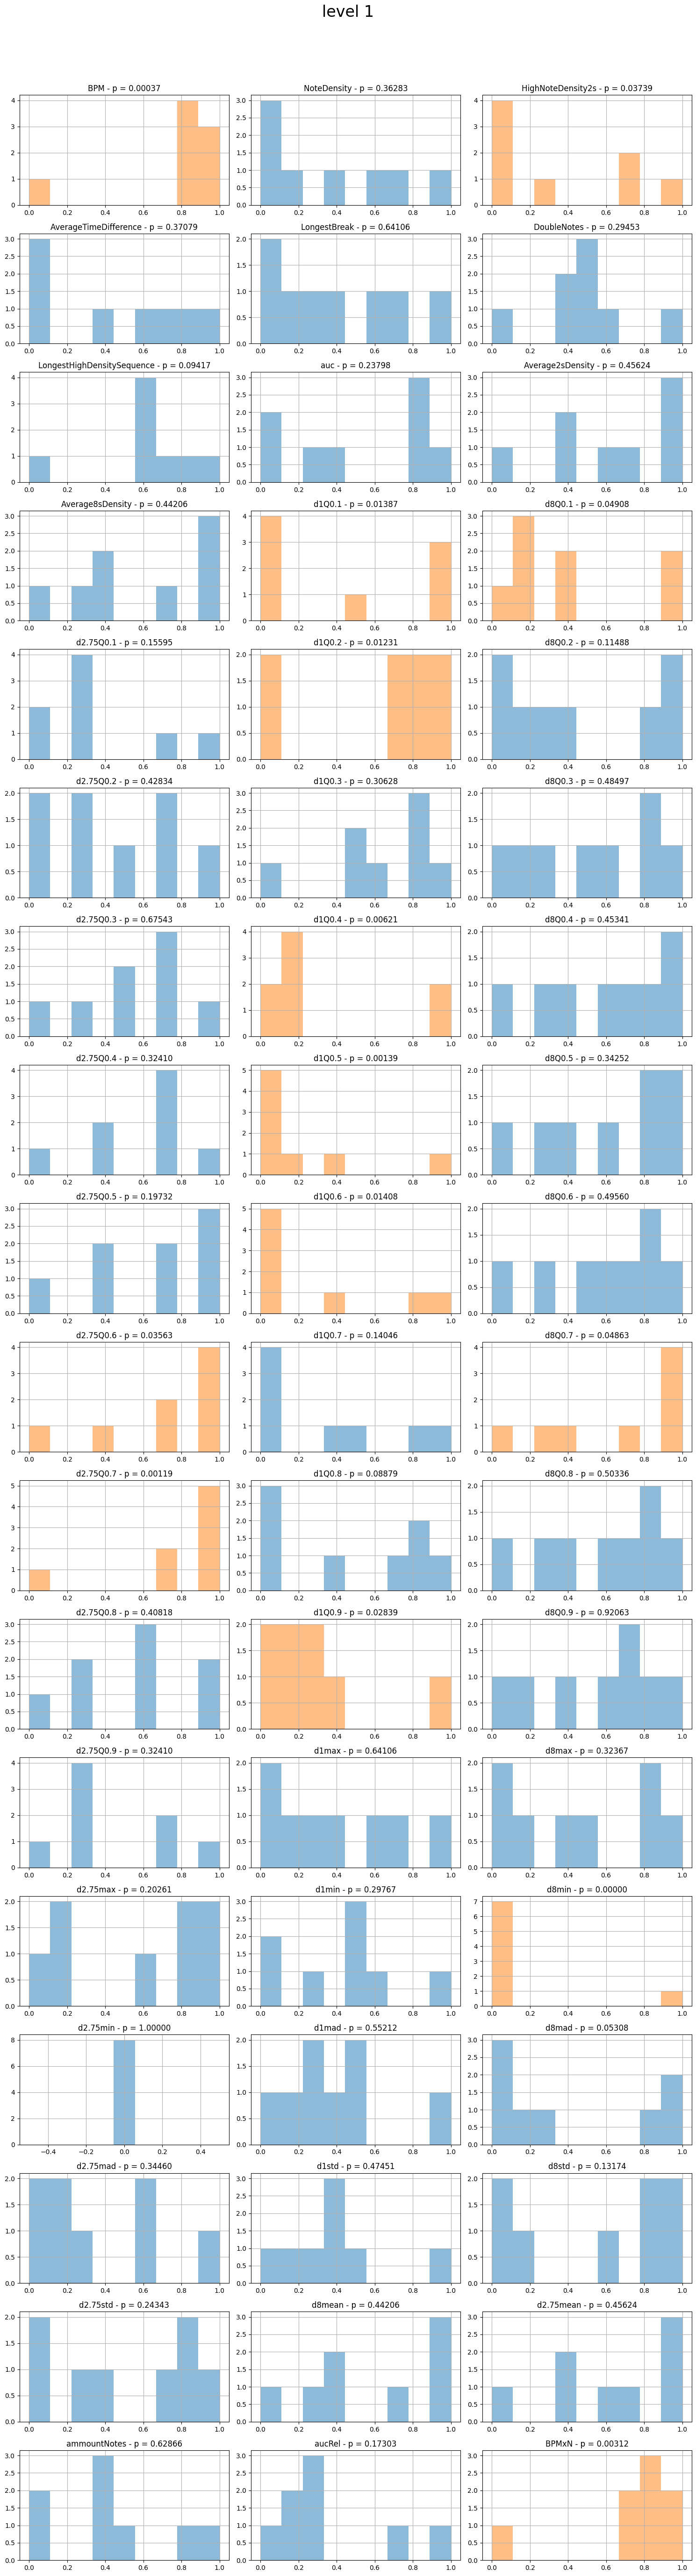

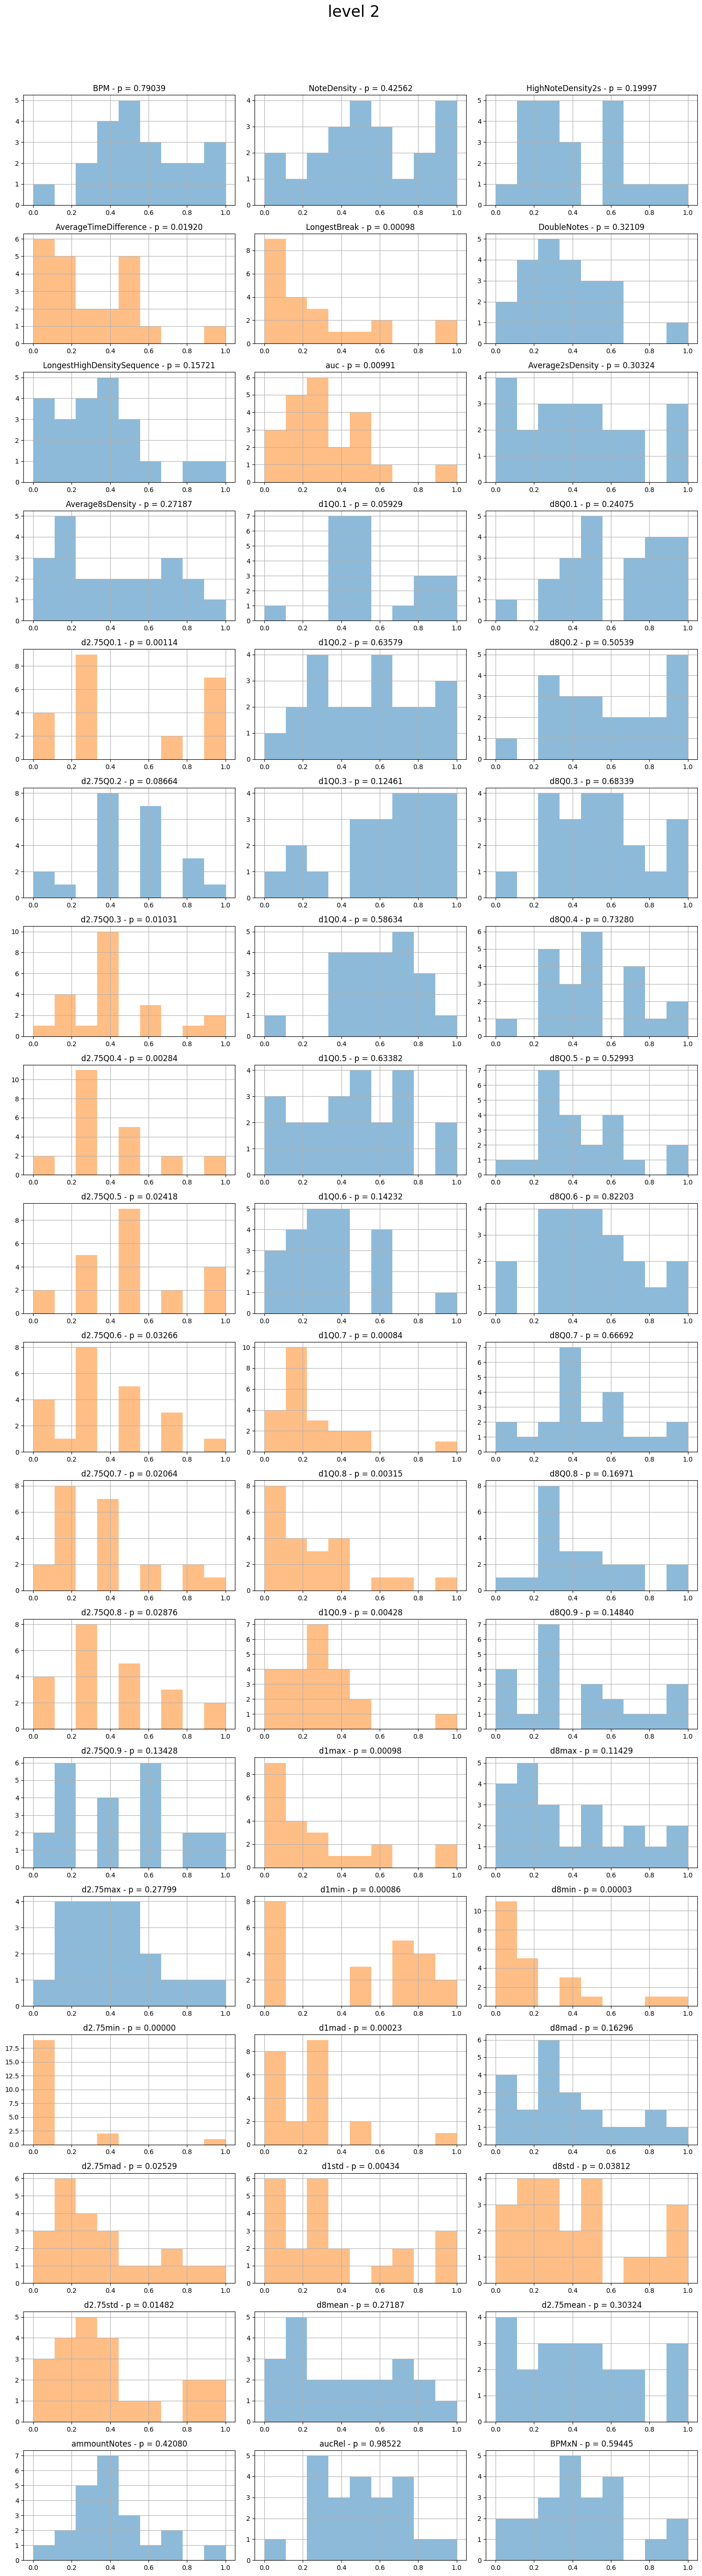

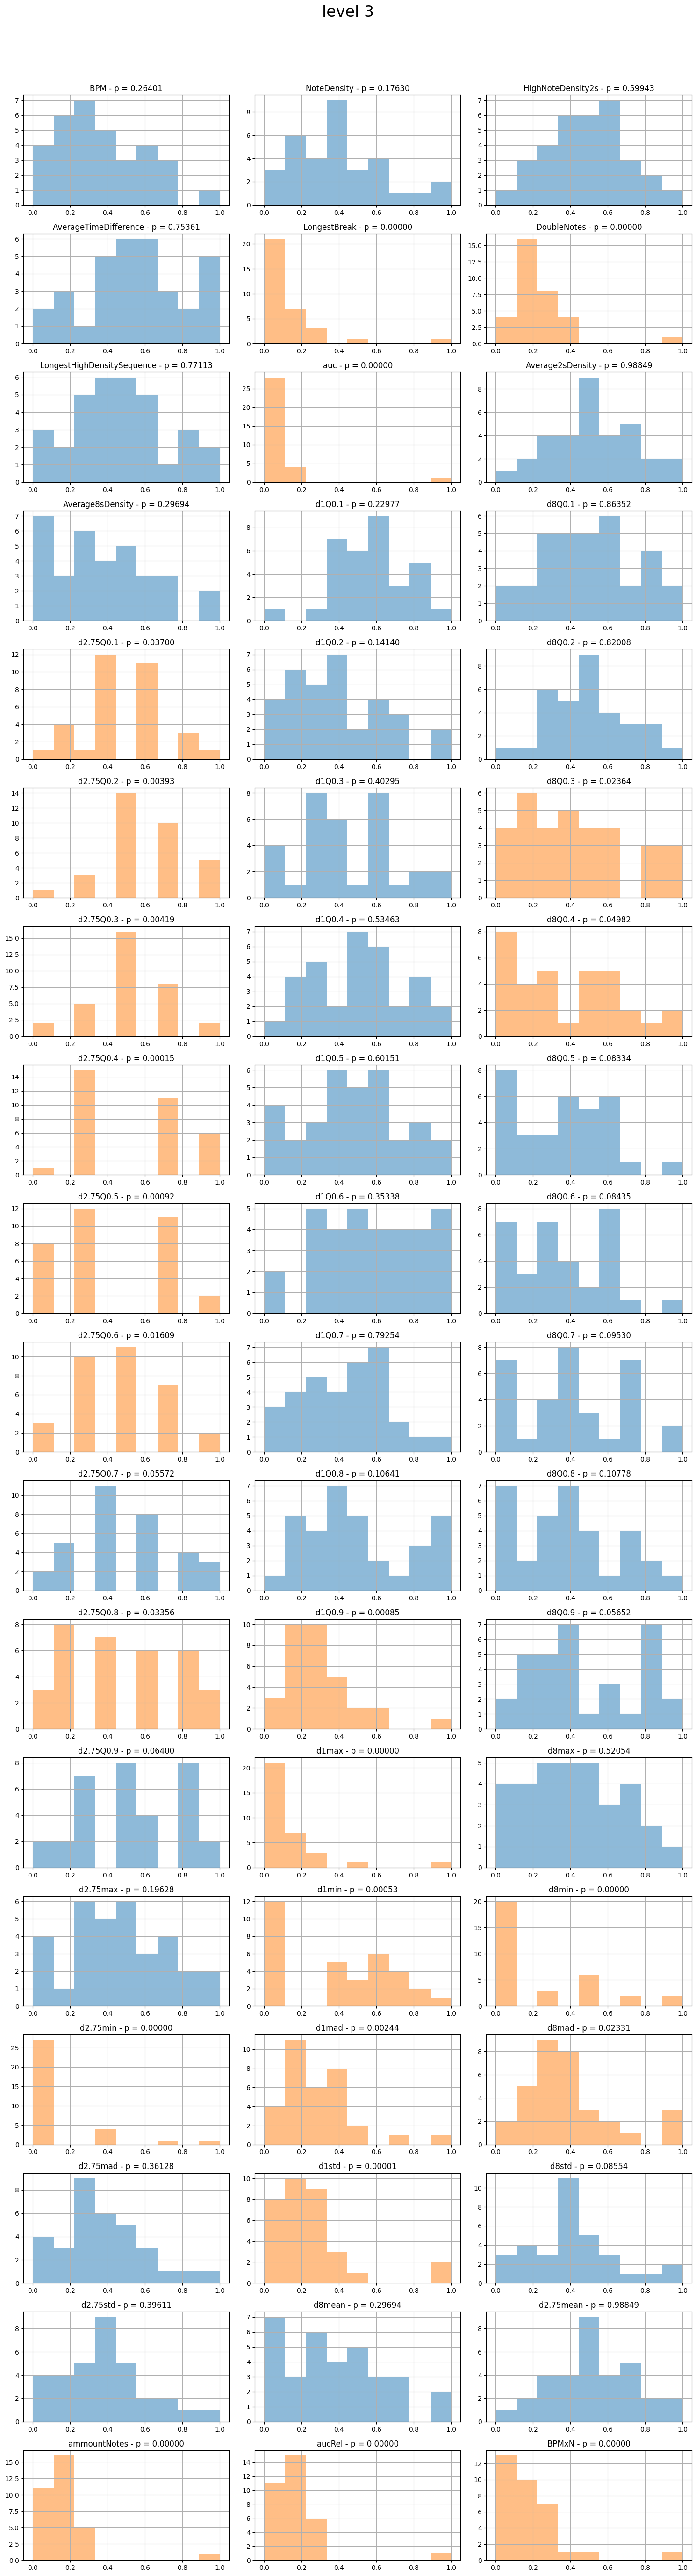

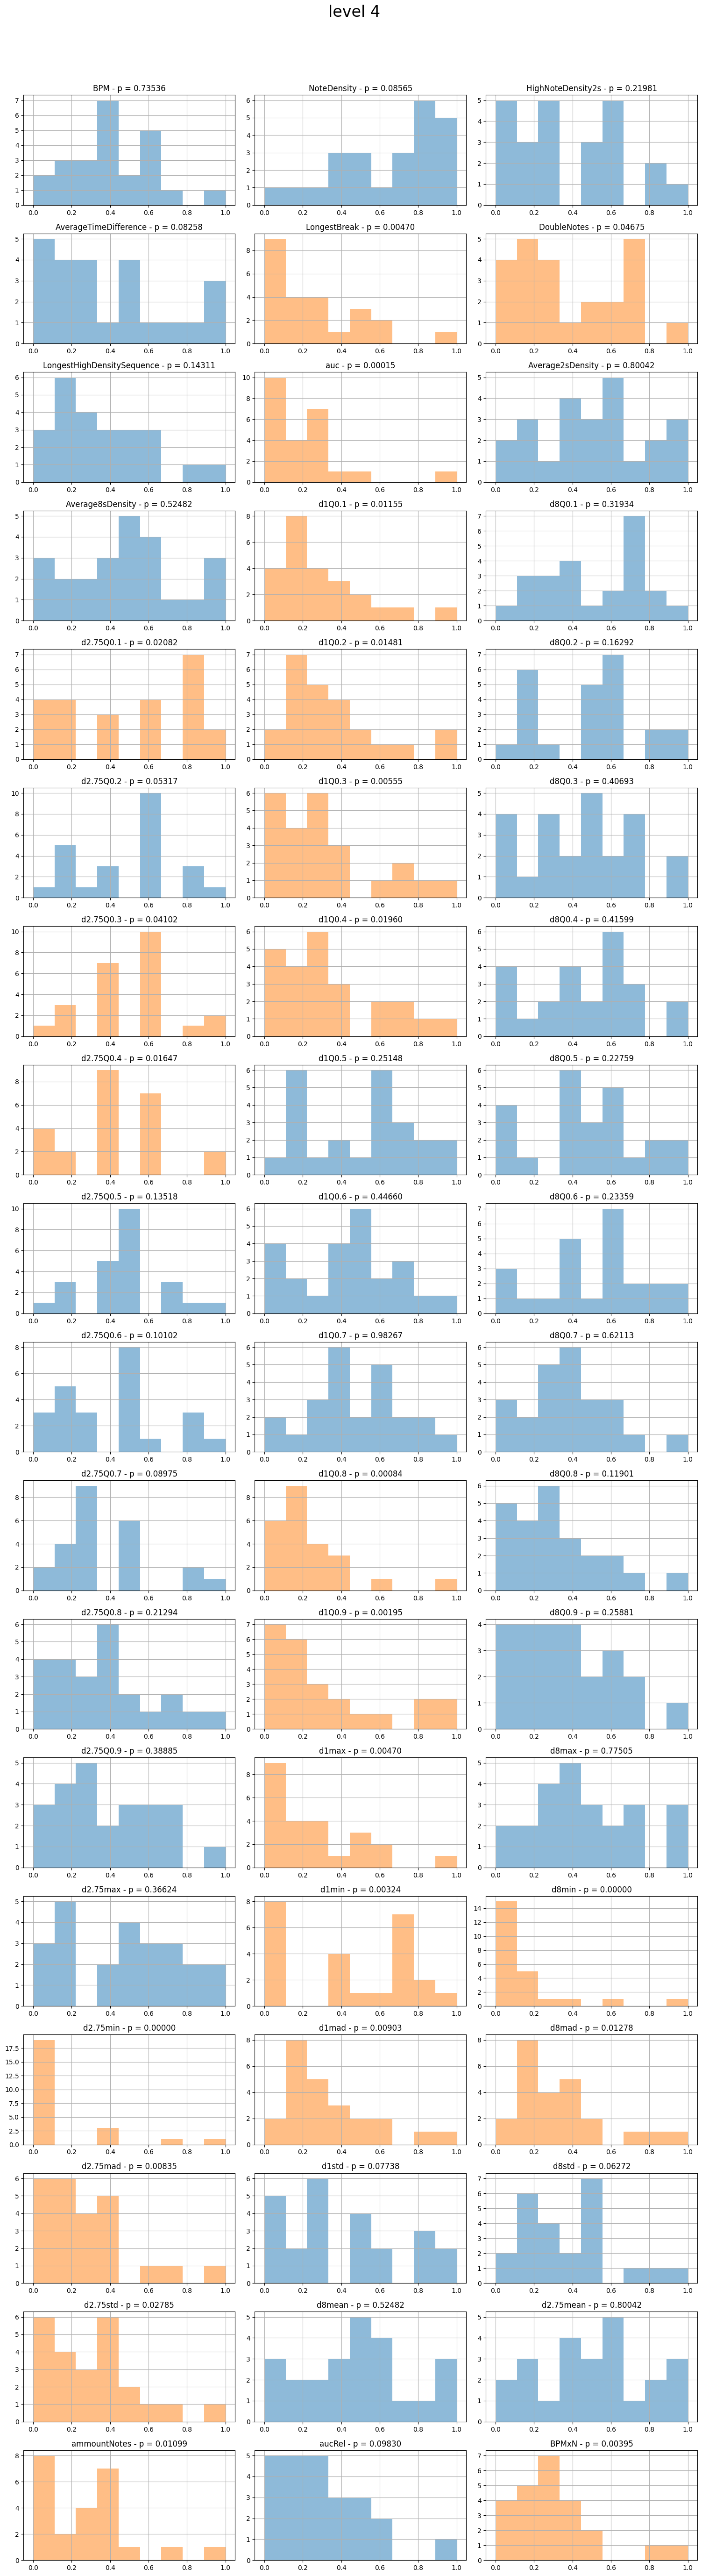

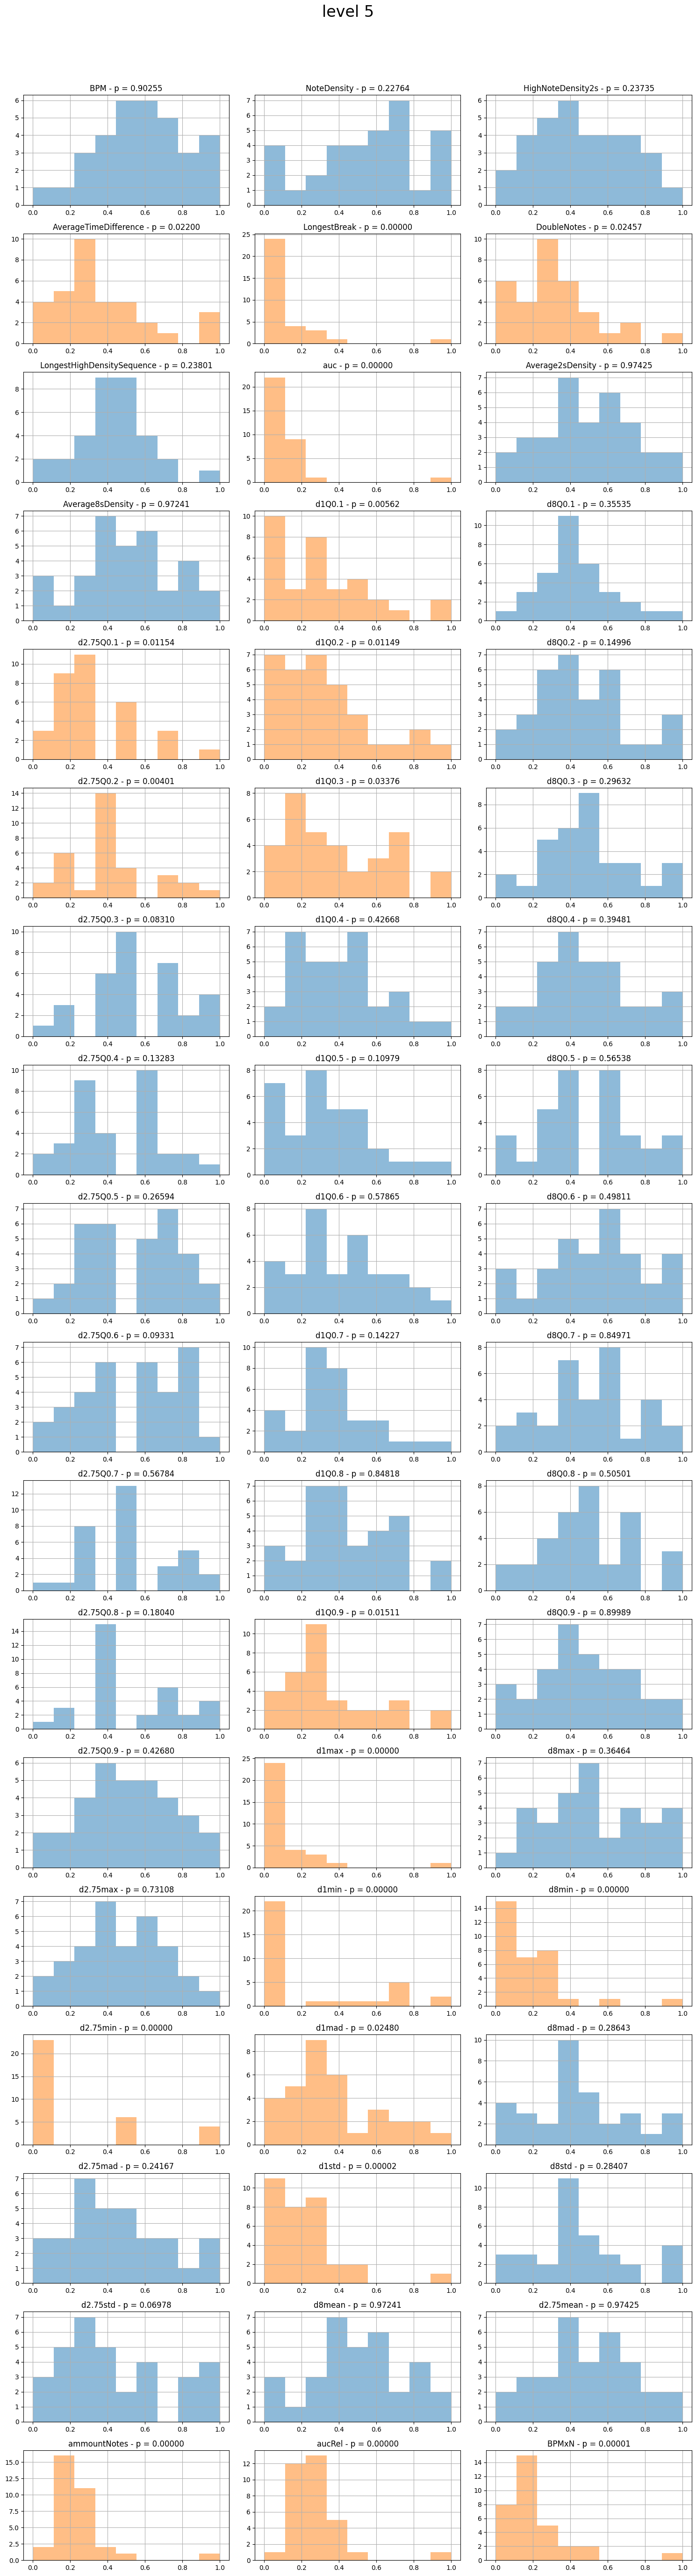

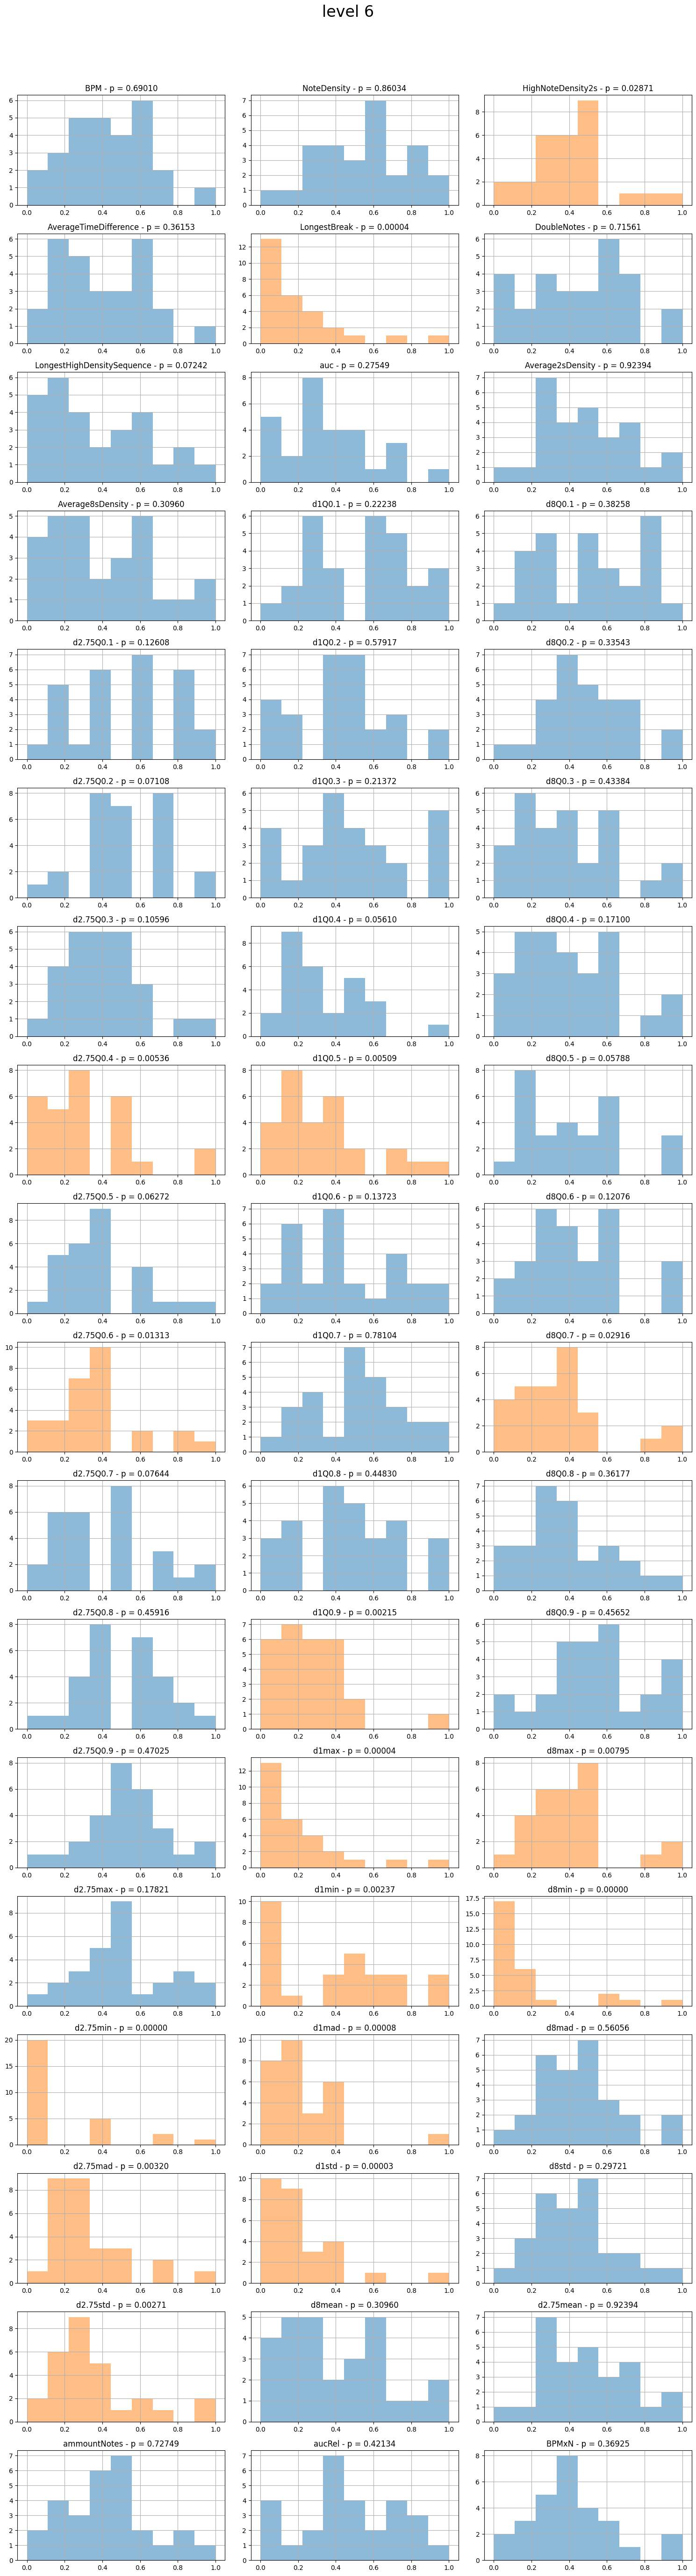

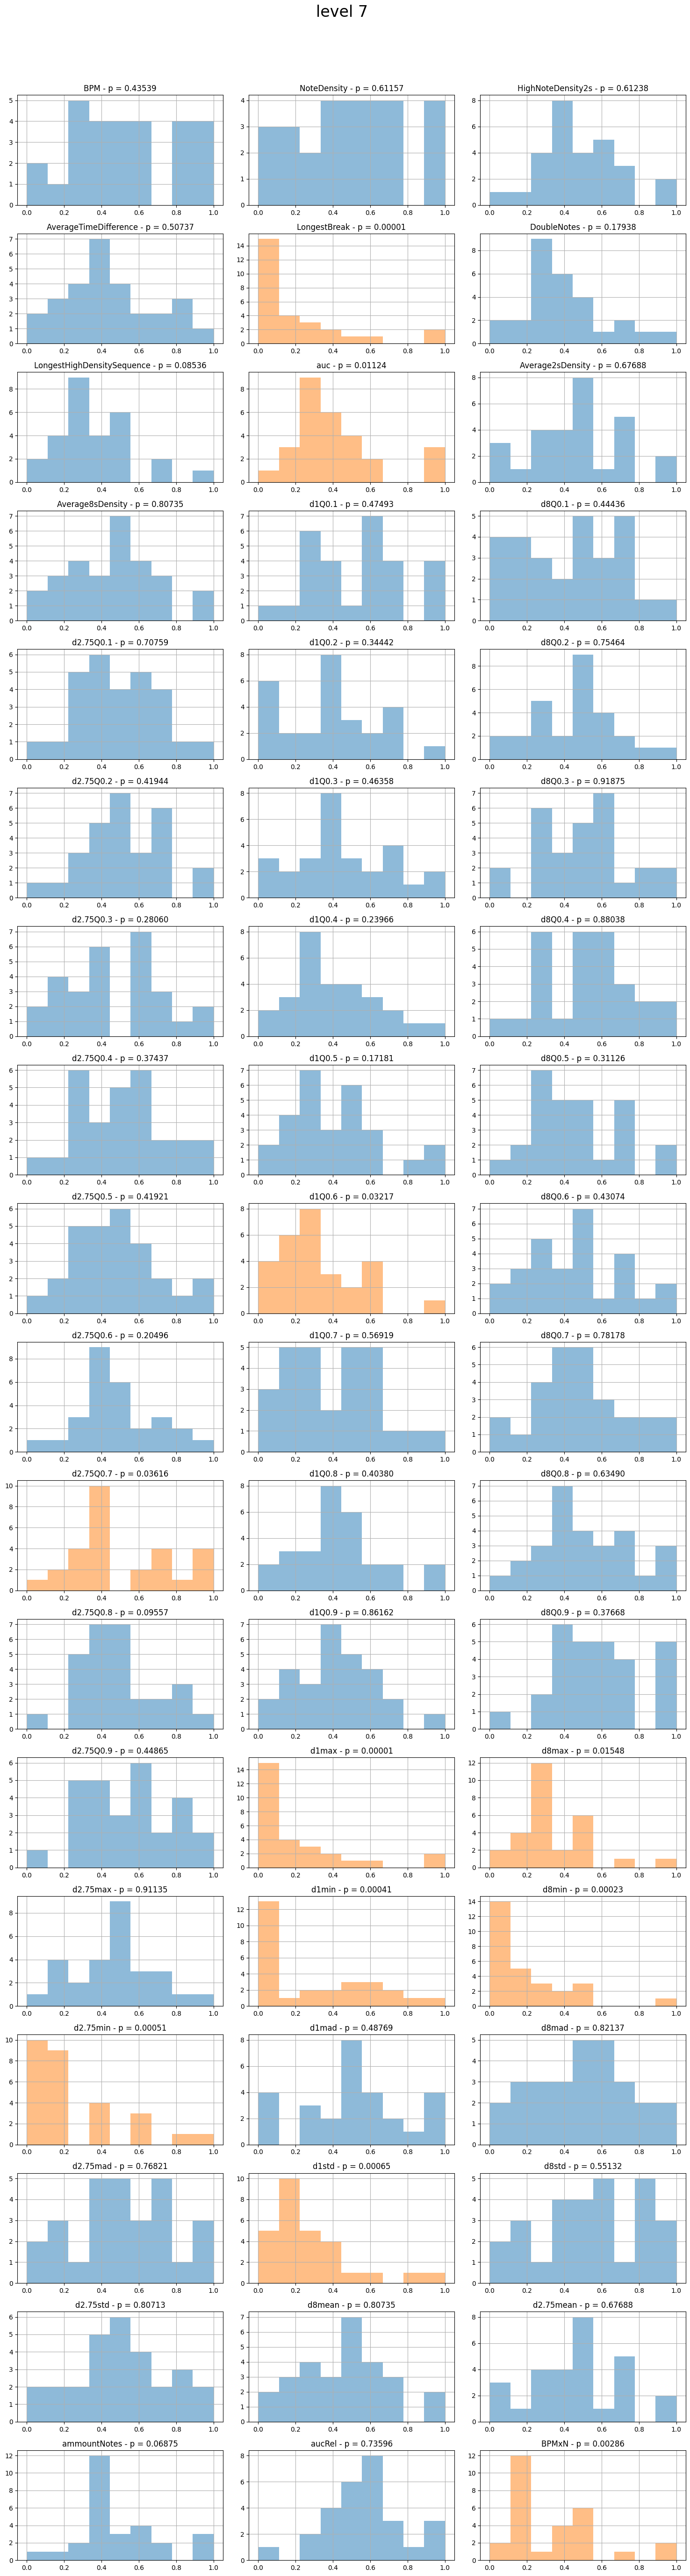

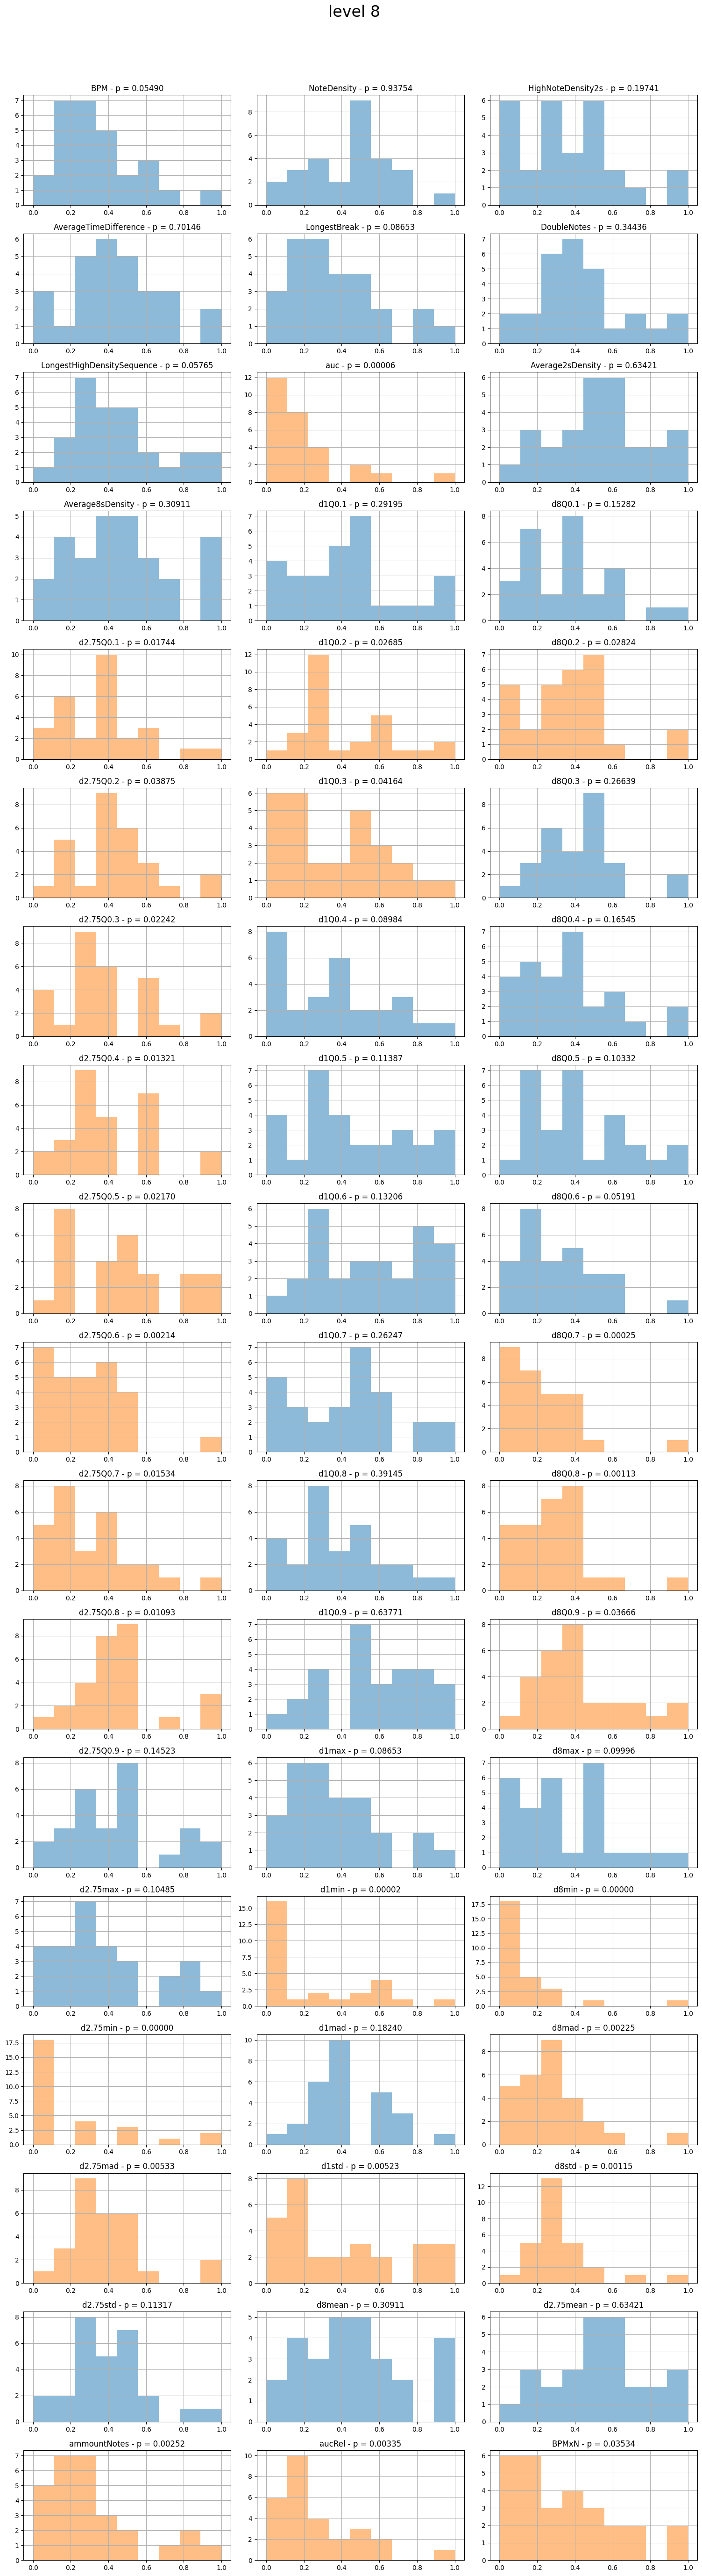

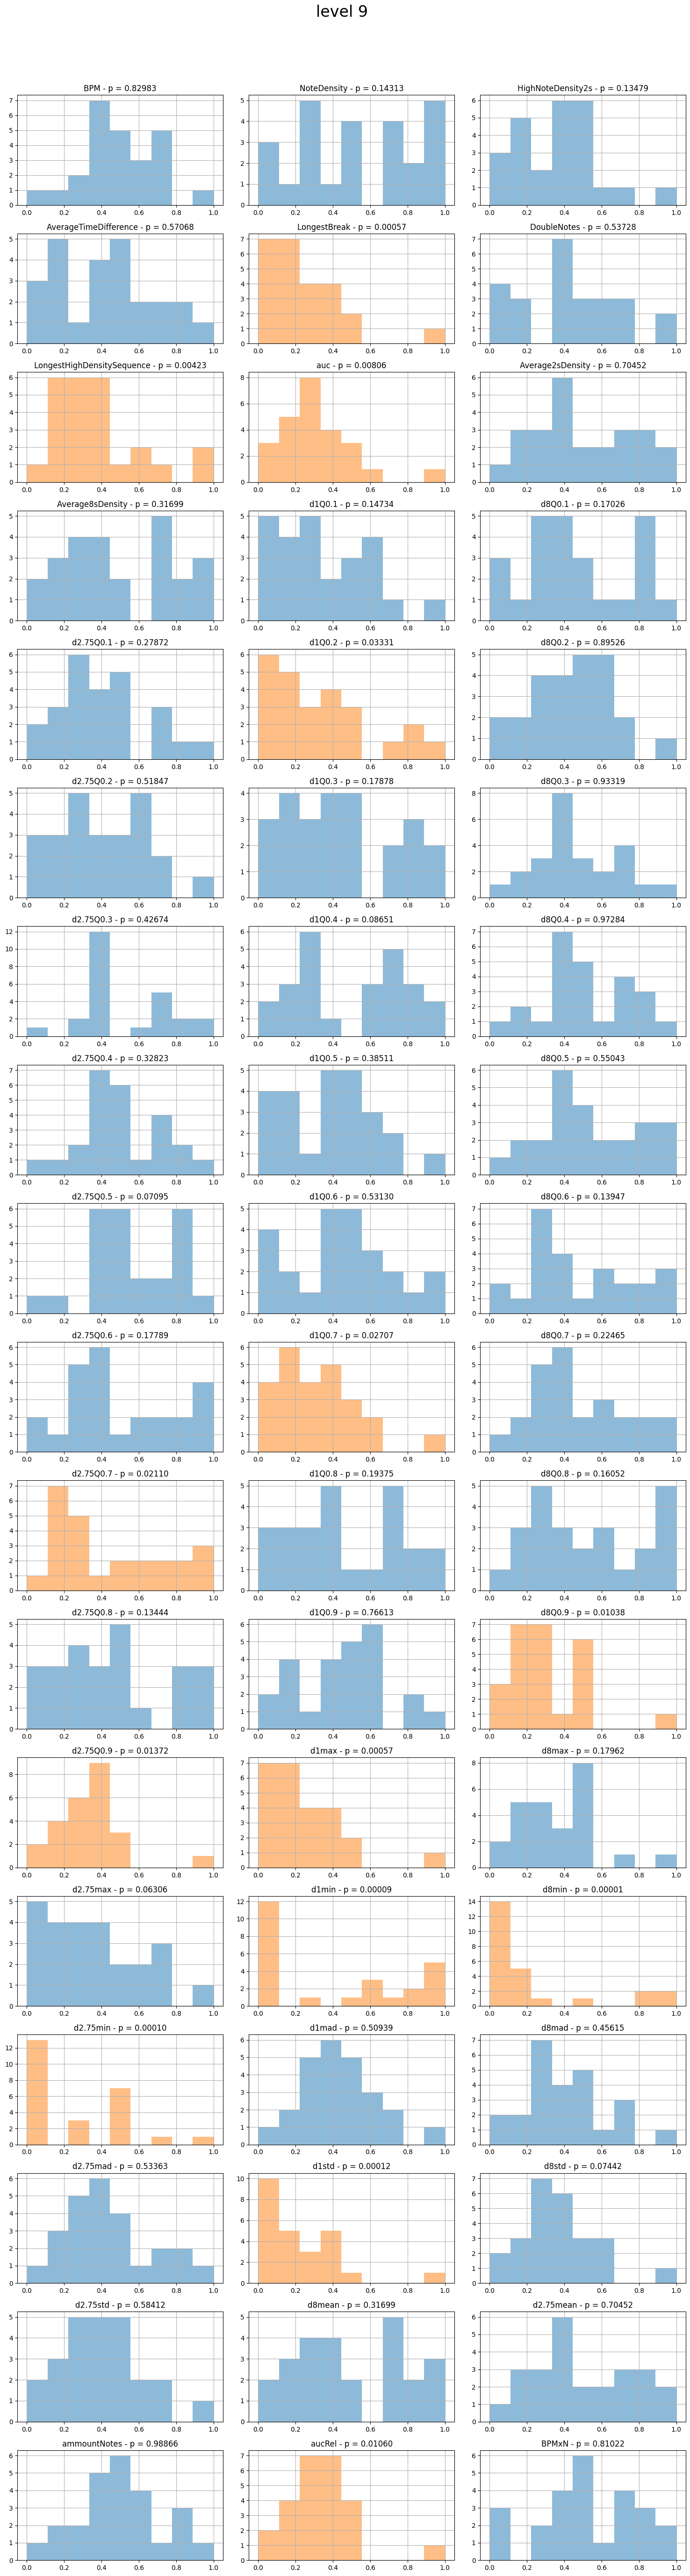

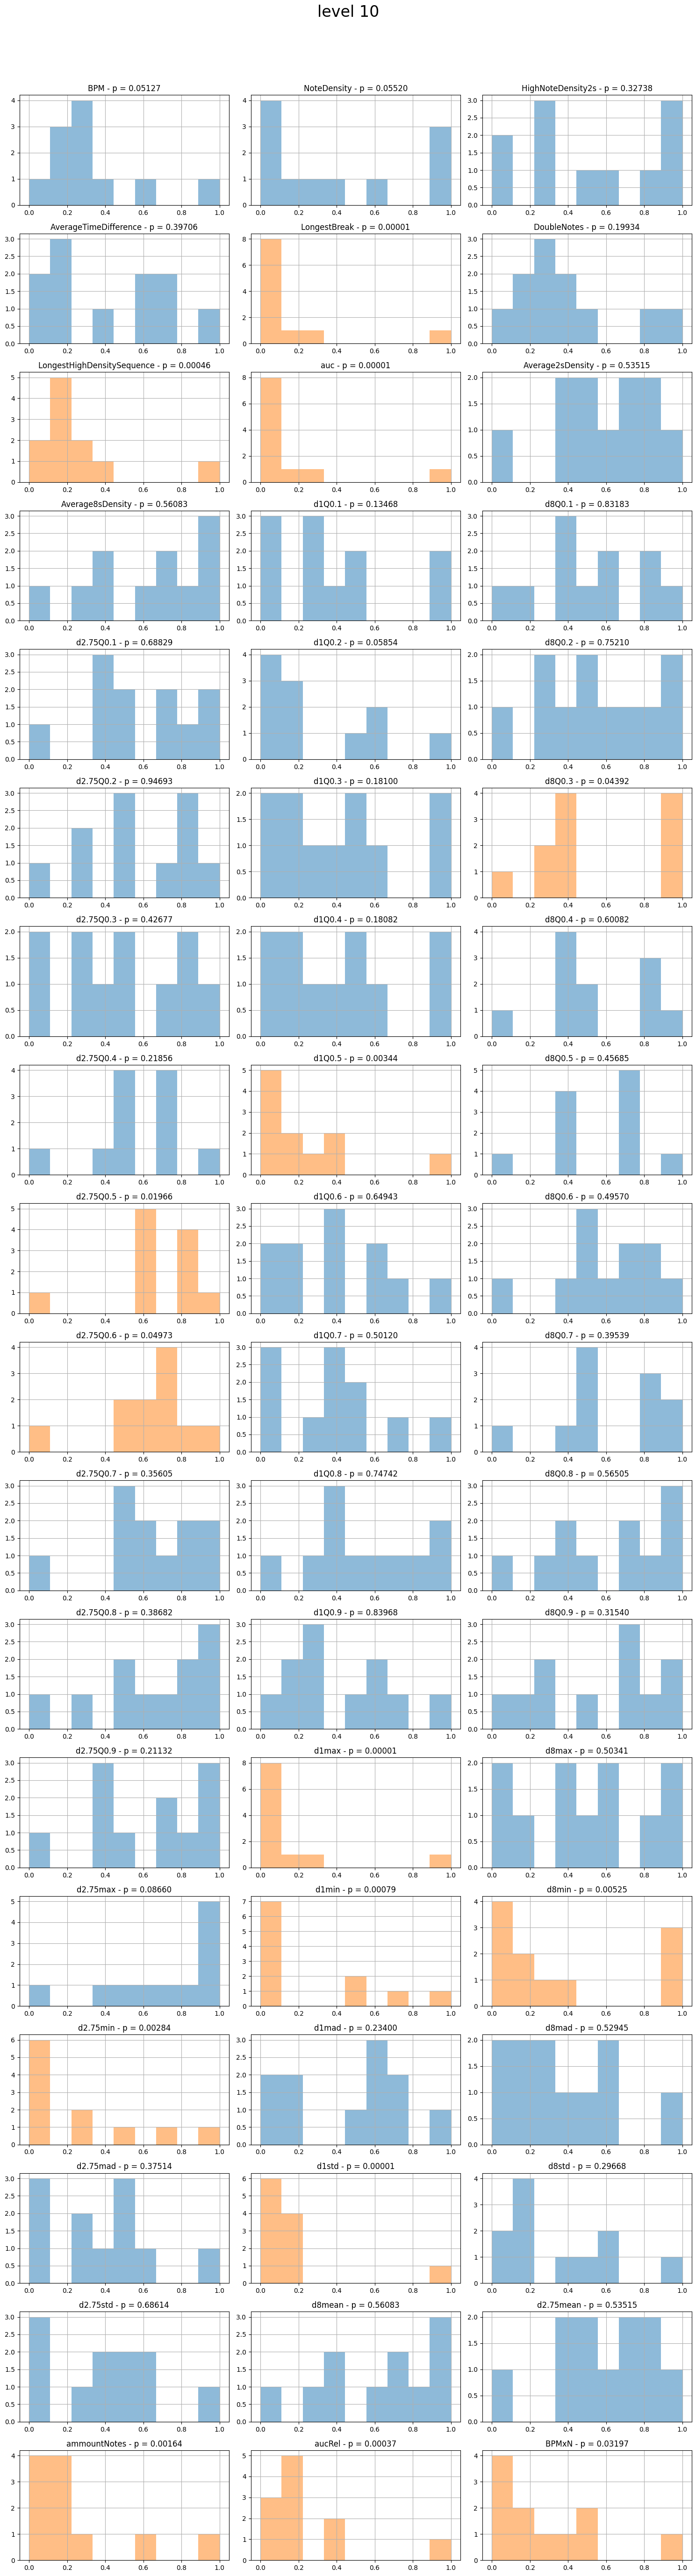

In [ ]:
# distribution
N = len(featureList)

for level in range(1, 11):
    plt.figure(figsize=(15, N))
    df_level = df.loc[df['Difficulty'] == level]
    for i, feature in enumerate(featureList):
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(df_level[[feature]])
        _, p_shapiro = stats.shapiro(X_scaled)
        color = cm.tab10.colors[0]
        if p_shapiro < 0.05:
            color = cm.tab10.colors[1]
        plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i + 1)
        plt.hist(X_scaled, bins=9, alpha=0.5, color=color)
        plt.title(f"{featureList[i]} - p = {p_shapiro:.5f}")
        plt.grid(True)

    plt.suptitle(f"level {level}", y=1.02, fontsize=24)
    plt.tight_layout()
    plt.show()


In [ ]:
def convert_to_dict(input_list):
    result_dict = {}
    for value, type_name in input_list:
        if type_name in result_dict:
            result_dict[type_name] += (value,)
        else:
            result_dict[type_name] = (value,)
    return result_dict

def generate_test_list(df):
    for level in range(1, 11):
        df_level = df.loc[df['Difficulty'] == level]
        for feature in featureList:
            _, p_shapiro = stats.shapiro(df_level[[feature]])
            if p_shapiro < 0.05:
                yield (level, feature)
convert_to_dict(list(generate_test_list(df)))

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


{'BPM': (1,),
 'd1Q0.1': (1, 2, 4, 5),
 'd8Q0.1': (1,),
 'd1Q0.2': (1, 4, 5, 8, 9),
 'd1Q0.3': (1, 4, 5, 8),
 'd1Q0.4': (1, 4),
 'd1Q0.5': (1, 6, 10),
 'd1Q0.6': (1, 7),
 'd2.75Q0.6': (1, 2, 3, 6, 8, 10),
 'd8Q0.7': (1, 6, 8),
 'd2.75Q0.7': (1, 2, 3, 4, 8, 9),
 'd1Q0.9': (1, 2, 3, 4, 5, 6),
 'd8min': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
 'd8mad': (1, 3, 4, 8),
 'BPMxN': (1, 3, 4, 5, 7, 8, 10),
 'HighNoteDensity2s': (2,),
 'LongestBreak': (2, 3, 4, 5, 6, 7, 9, 10),
 'auc': (2, 3, 4, 5, 7, 8, 9, 10),
 'd2.75Q0.1': (2, 3, 4, 5, 8),
 'd2.75Q0.3': (2, 3, 8),
 'd2.75Q0.4': (2, 3, 4, 6, 8),
 'd2.75Q0.5': (2, 3, 8),
 'd1Q0.7': (2,),
 'd1Q0.8': (2, 4),
 'd8Q0.8': (2, 8),
 'd2.75Q0.8': (2, 7, 8),
 'd1max': (2, 3, 4, 5, 6, 7, 9, 10),
 'd8max': (2, 6, 7),
 'd1min': (2, 3, 5, 8),
 'd2.75min': (2, 3, 4, 5, 6, 7, 8, 9, 10),
 'd1mad': (2, 3, 4, 5, 6),
 'd1std': (2, 3, 5, 6, 7, 8, 9, 10),
 'd8std': (2, 8),
 'd2.75std': (2, 4, 6),
 'LongestHighDensitySequenceAverage': (2, 3, 4, 5, 7),
 'DoubleNotes': (3, 4,

## univariate

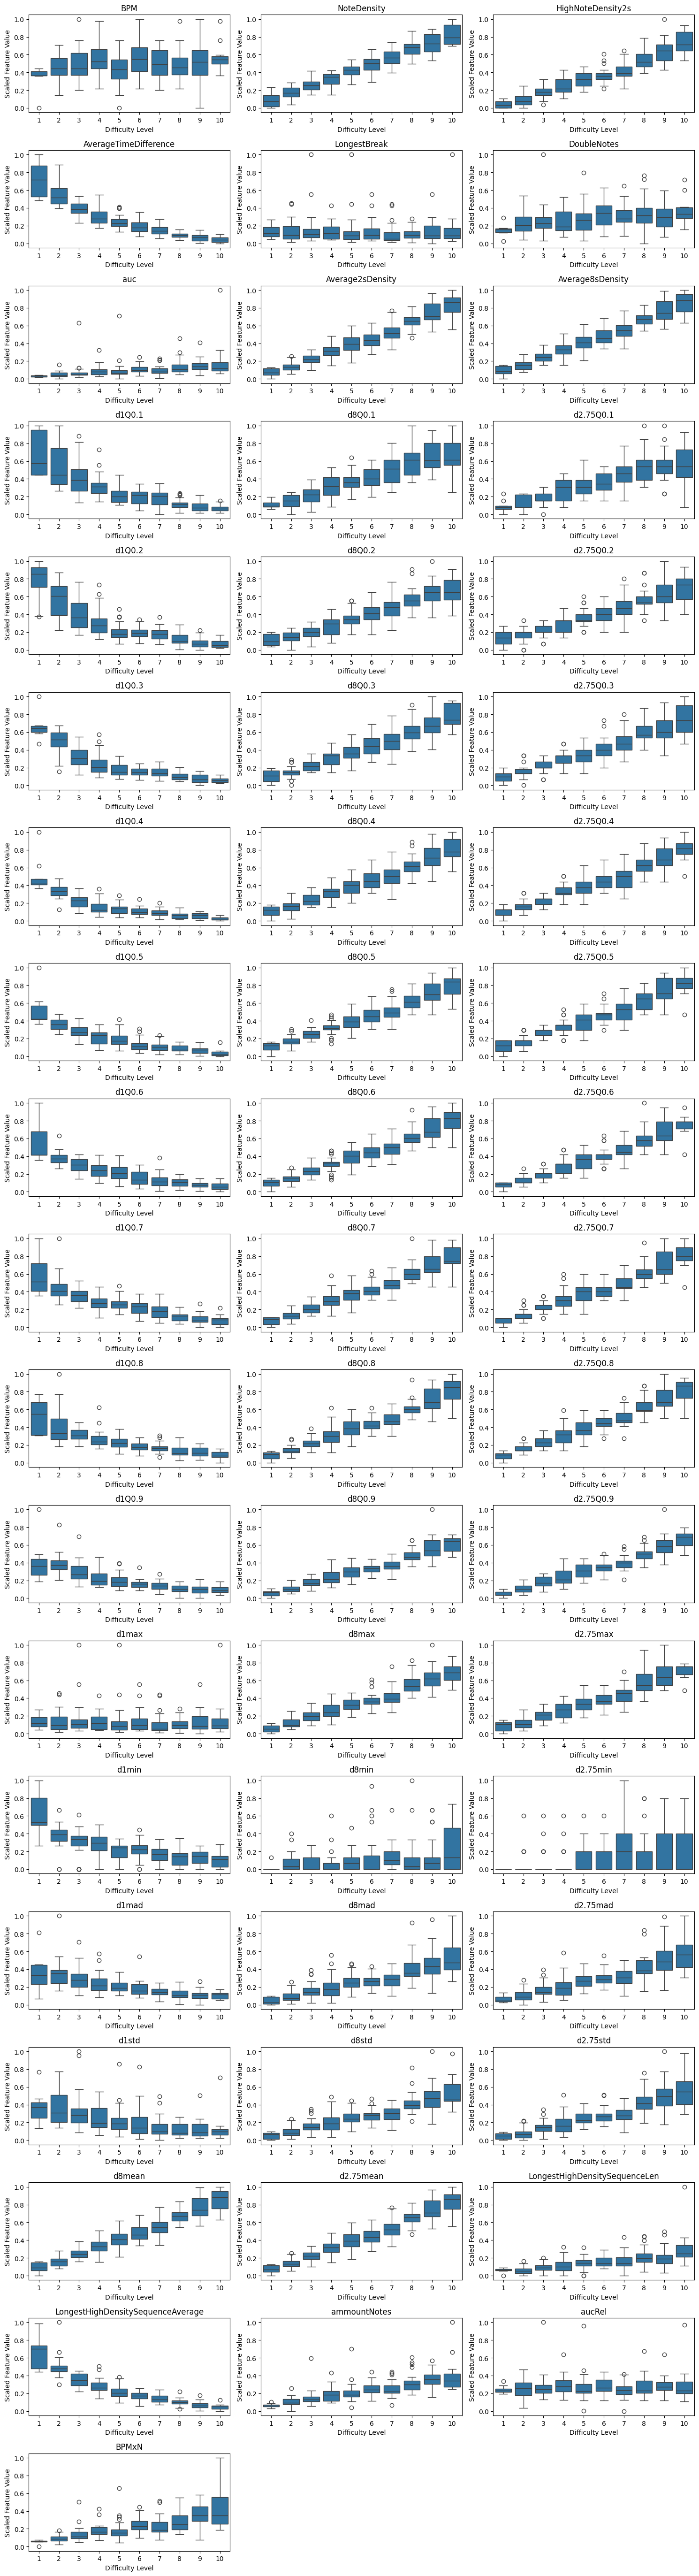

In [ ]:
N = len(featureList)
X = df[featureList]
y = df[targetFeature]

plt.figure(figsize=(15, N))
for i in range(N):
    plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i % N + 1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.iloc[:, i].values.reshape(-1, 1))

    sns.boxplot(x=y.Difficulty, y=X_scaled.squeeze())
    plt.xlabel('Difficulty Level')
    plt.ylabel('Scaled Feature Value')
    plt.title(featureList[i])

plt.tight_layout()
plt.show()


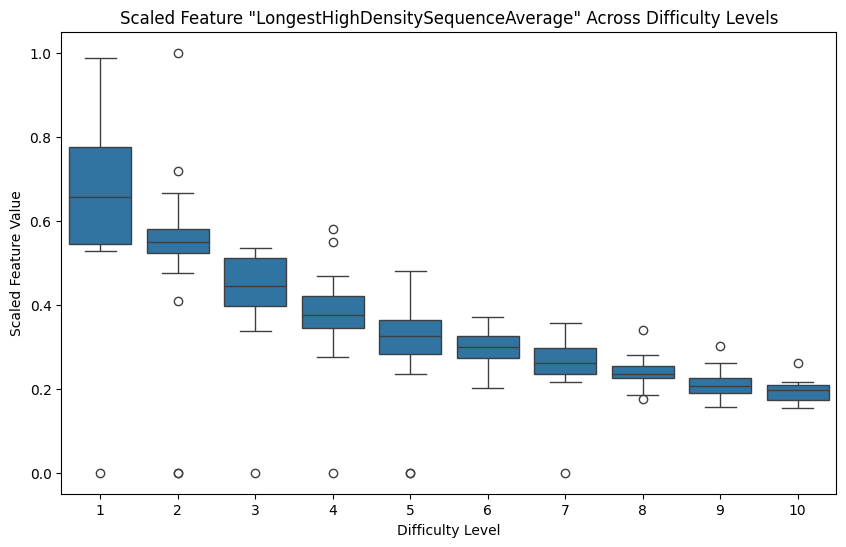

In [ ]:
feature_number = 51

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.iloc[:, feature_number].values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.boxplot(x=y.Difficulty, y=X_scaled.squeeze())
plt.xlabel('Difficulty Level')
plt.ylabel('Scaled Feature Value')
plt.title('Scaled Feature "' + featureList[feature_number] + '" Across Difficulty Levels')
plt.show()


## basic model

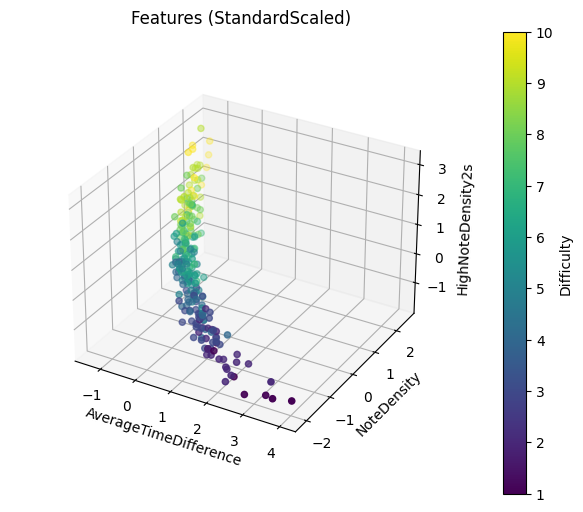

In [ ]:
X_dimensions = ["AverageTimeDifference", "NoteDensity", "HighNoteDensity2s"]
targetFeature = ["Difficulty"]
X = df[X_dimensions]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y.values, cmap='viridis')

ax.set_xlabel(X_dimensions[0])
ax.set_ylabel(X_dimensions[1])
ax.set_zlabel(X_dimensions[2])
ax.set_title('Features (StandardScaled)')

ax.set_box_aspect(None, zoom=0.85)

cbar = fig.colorbar(scatter, ax=ax, label='Difficulty')

plt.show()


## 2d

In [ ]:
x_test_dims = ["NoteDensity", "AverageTimeDifference", "LongestHighDensitySequenceLen", "HighNoteDensity2s"]

The interpretation is simple: we have a better classification if each group is close to each other in a narrow range and well delimited from other groups

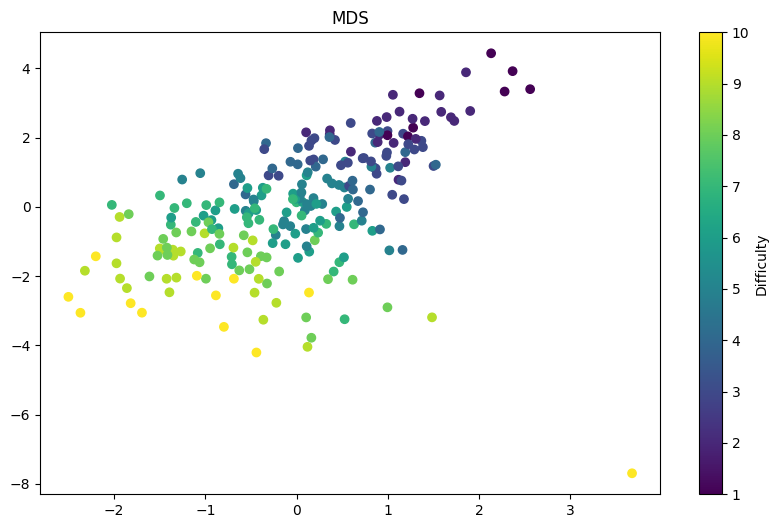

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = MDS(n_components=2, normalized_stress='auto')
transformed_data = model.fit_transform(X_scaled)

df['MDS_1'] = transformed_data[:, 0]
df['MDS_2'] = transformed_data[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['MDS_1'], df['MDS_2'], c=y.Difficulty, cmap='viridis')
plt.title('MDS')
plt.colorbar(label='Difficulty')
plt.show()


MDS: Optimized visualization of similarities or differences between data points in a low-dimensional space

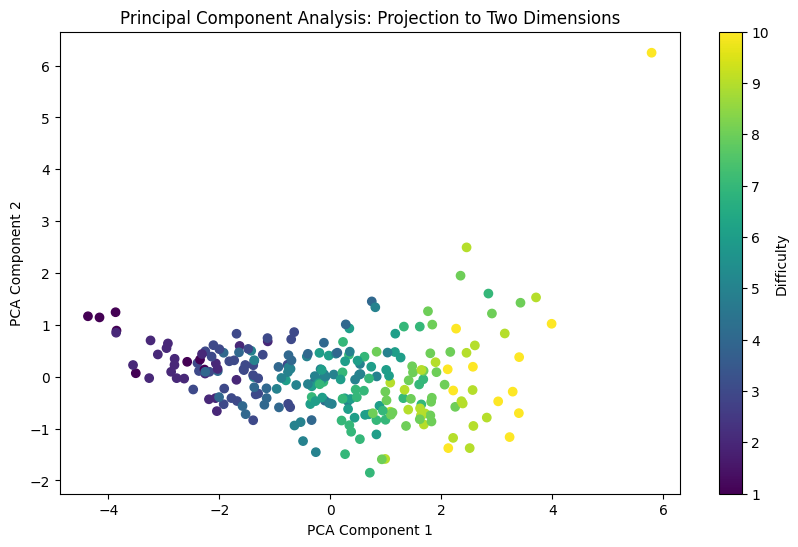

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA_Component_1'] = X_pca[:, 0]
df['PCA_Component_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.Difficulty, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Principal Component Analysis: Projection to Two Dimensions')
plt.colorbar(label='Difficulty')
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM
X_pca = df[['PCA_Component_1', 'PCA_Component_2']].values
detector = OneClassSVM(nu=0.01)
outlier_labels = detector.fit_predict(X_pca)
df['Outlier'] = outlier_labels
print(df[df['Outlier'] == -1][['SongName', 'Difficulty']])

                                SongName  Difficulty
27                                 Nitro           1
41                  The Land of Unicorns           9
98               The Great Pirate Bottle          10
102                    Call of the North           2
139                            Löwenherz           4
155                                Vodka           7
207  The Fires of Ancient Cosmic Destiny           3
227                         Loose Cannon           9
237                            Ambiramus           2
238                            Ambiramus           4


In [ ]:
df.loc[df['PCA_Component_2'].idxmax()][['SongName', 'Difficulty']]

SongName      The Fires of Ancient Cosmic Destiny
Difficulty                                     10
Name: 209, dtype: object

In LDA, the class information of the data is used to find an optimal linear discriminant that enables maximum separation between the classes. (better groups -> correlation in classdepenecy)

PCA: the class information is not relevant

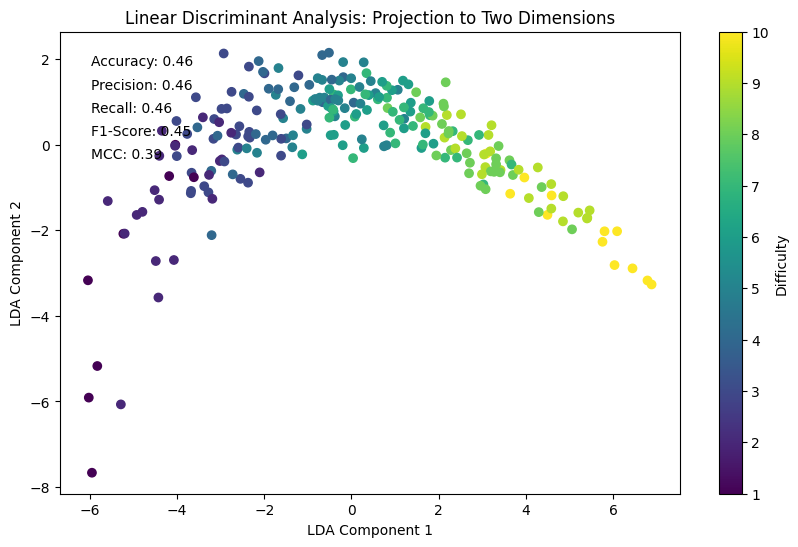

In [ ]:
X = df[x_test_dims]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_encoded)

df['LDA_Component_1'] = X_lda[:, 0]
df['LDA_Component_2'] = X_lda[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y.Difficulty, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('Linear Discriminant Analysis: Projection to Two Dimensions')
plt.colorbar(label='Difficulty')

y_pred = lda.predict(X_scaled)
accuracy = lda.score(X_scaled, y_encoded)
precision = metrics.precision_score(y_encoded, y_pred, average='weighted')
recall = metrics.recall_score(y_encoded, y_pred, average='weighted')
f1 = metrics.f1_score(y_encoded, y_pred, average='weighted')
MCC = metrics.matthews_corrcoef(y_encoded, y_pred)

settings = {'transform': plt.gca().transAxes, 'fontsize': 10, 'verticalalignment': 'top'}
plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', **settings)
plt.text(0.05, 0.90, f'Precision: {precision:.2f}', **settings)
plt.text(0.05, 0.85, f'Recall: {recall:.2f}', **settings)
plt.text(0.05, 0.80, f'F1-Score: {f1:.2f}', **settings)
plt.text(0.05, 0.75, f'MCC: {MCC:.2f}', **settings)
plt.show()

In [ ]:
df.loc[df['LDA_Component_1'].idxmax()][['SongName', 'Difficulty']]

SongName      The Land of Unicorns
Difficulty                      10
Name: 41, dtype: object

In [ ]:
df.loc[41, 'Difficulty'] = 10
df.loc[53, 'Difficulty'] = 9

In [ ]:
df.loc[df['Difficulty'] == 9].sort_values(by='LDA_Component_1')[['SongName', 'Difficulty']]

SongName  Difficulty
56                Universe on fire           9
26                     Evier metal           9
53                          Whaole           9
86                         Skyfall           9
68                 Mine Mine Mine!           9
236                Drunken dwarves           9
227                   Loose Cannon           9
218                 Randy Dandy Oh           9
131             One Night In Tokyo           9
29                           Nitro           9
170                  Stormtroopers           9
47                      Kampfzwerg           9
2                  Man the Cannons           9
215          Masters of The Galaxy           9
230               Steel Commanders           9
221              A Man With A Plan           9
50                         Iridium           9
224  Life Will Always Find Its Way           9
113                     Revolution           9
164                  Abyss Of Time           9
107           No Grave But The Sea           9
200      Rise of the Chaos Wizards           9
203           The Siege of Dunkeld           9
11                           Niemi           9

In [ ]:
feature_weighting = pd.DataFrame(lda.coef_, columns=X.columns, index=sorted(y.Difficulty.unique()))
feature_weighting['MaxInfluence'] = feature_weighting[X.columns].apply(max_abs_column_name, axis=1)
feature_weighting['sMaxInfluence'] = feature_weighting[X.columns].apply(second_max_abs_column_name, axis=1)
feature_weighting['MinInfluence'] = feature_weighting[X.columns].apply(min_abs_column_name, axis=1)

feature_weighting

NoteDensity  AverageTimeDifference  HighNoteDensity2s  \
1     -0.467279              12.156122          -3.232426   
2     -3.056297               5.187200          -3.593360   
3     -4.775334              -0.209647          -3.206505   
4     -4.707476              -2.310880          -2.179830   
5     -2.931875              -2.854068          -1.174139   
6     -0.723972              -2.457544          -0.298916   
7      1.497521              -1.915430           0.355066   
8      4.675173              -0.279015           2.940795   
9      6.488300               1.060341           5.613072   
10    11.229305               4.449407           7.049934   

    LongestHighDensitySequenceLen           MaxInfluence  \
1                        0.048686  AverageTimeDifference   
2                       -0.333484  AverageTimeDifference   
3                       -0.201722            NoteDensity   
4                       -0.187437            NoteDensity   
5                       -0.119907            NoteDensity   
6                        0.009445  AverageTimeDifference   
7                       -0.086481  AverageTimeDifference   
8                        0.390501            NoteDensity   
9                       -0.087113            NoteDensity   
10                       1.405471            NoteDensity   

            sMaxInfluence                   MinInfluence  
1       HighNoteDensity2s  LongestHighDensitySequenceLen  
2       HighNoteDensity2s  LongestHighDensitySequenceLen  
3       HighNoteDensity2s  LongestHighDensitySequenceLen  
4   AverageTimeDifference  LongestHighDensitySequenceLen  
5   AverageTimeDifference  LongestHighDensitySequenceLen  
6             NoteDensity  LongestHighDensitySequenceLen  
7             NoteDensity  LongestHighDensitySequenceLen  
8       HighNoteDensity2s          AverageTimeDifference  
9       HighNoteDensity2s  LongestHighDensitySequenceLen  
10      HighNoteDensity2s  LongestHighDensitySequenceLen

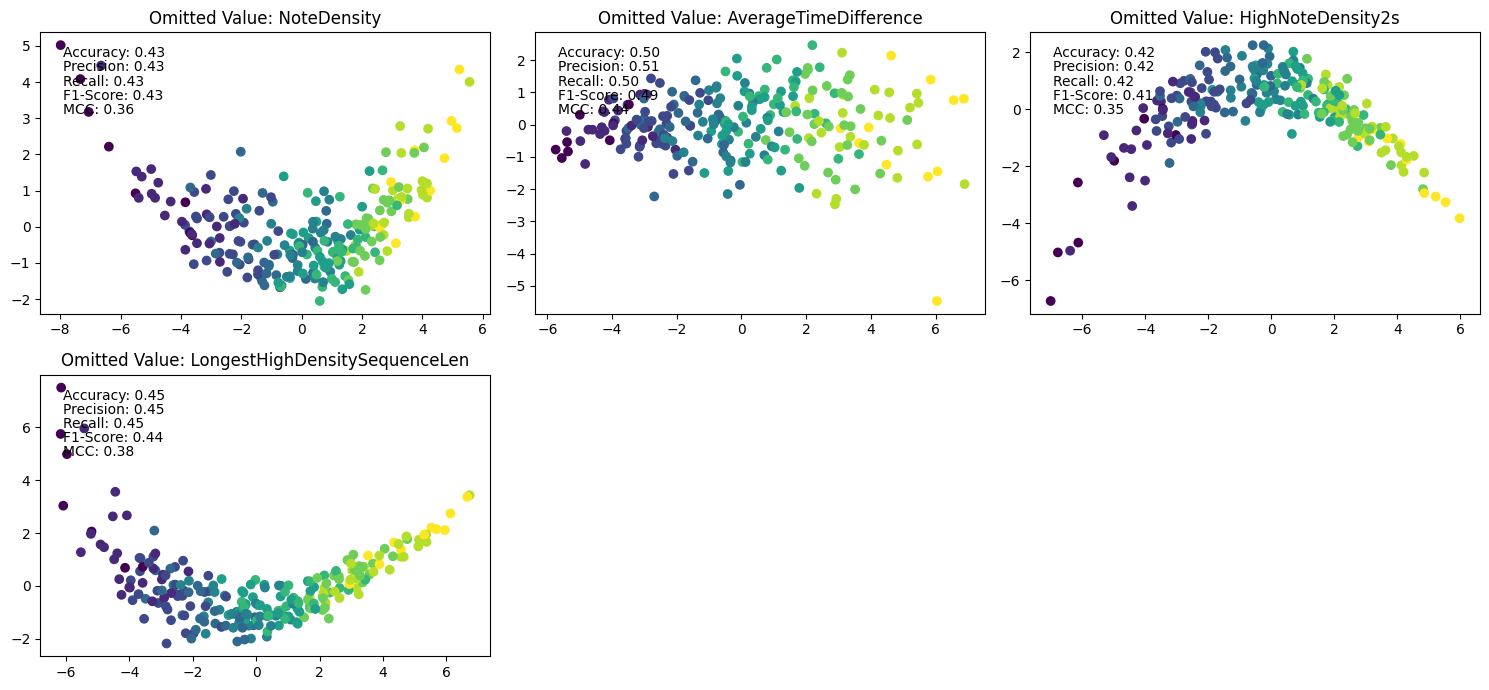

In [ ]:
featureList = x_test_dims
y = df[targetFeature]
N = len(featureList)
plt.figure(figsize=(15, N * 1.75))

for i, (features, omitted_value) in enumerate(generate_leave_one_value_out_sequence(featureList)):
    plt.subplot((N // 3) + (1 if N % 3 != 0 else 0), 3, i % N + 1)
    X = df[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y.values.ravel())

    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_scaled, y_encoded)

    df['LDA_Component_1'] = X_lda[:, 0]
    df['LDA_Component_2'] = X_lda[:, 1]

    plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y.Difficulty, cmap='viridis')

    plt.title(f'Omitted Value: {omitted_value}')

    y_pred = lda.predict(X_scaled)

    accuracy = lda.score(X_scaled, y_encoded)
    precision = metrics.precision_score(y_encoded, y_pred, average='weighted')
    recall = metrics.recall_score(y_encoded, y_pred, average='weighted')
    f1 = metrics.f1_score(y_encoded, y_pred, average='weighted')
    MCC = metrics.matthews_corrcoef(y_encoded, y_pred)

    settings = {'transform': plt.gca().transAxes, 'fontsize': 10, 'verticalalignment': 'top'}
    plt.text(0.05, 0.95, f'Accuracy: {accuracy:.2f}', **settings)
    plt.text(0.05, 0.90, f'Precision: {precision:.2f}', **settings)
    plt.text(0.05, 0.85, f'Recall: {recall:.2f}', **settings)
    plt.text(0.05, 0.80, f'F1-Score: {f1:.2f}', **settings)
    plt.text(0.05, 0.75, f'MCC: {MCC:.2f}', **settings)

plt.tight_layout()
plt.show()

## 1d

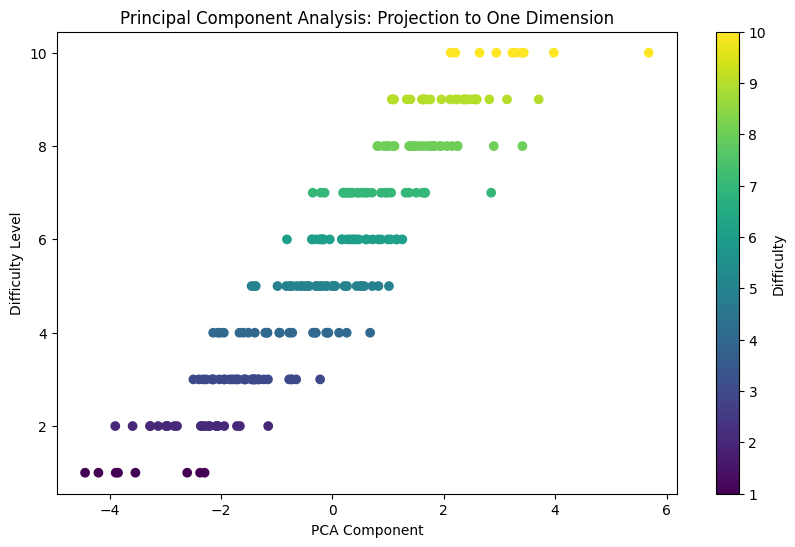

In [ ]:
X = df[featureList]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

df['PCA_Component'] = X_pca.squeeze()

plt.figure(figsize=(10, 6))
plt.scatter(X_pca, y, c=y.Difficulty, cmap='viridis')
plt.xlabel('PCA Component')
plt.ylabel('Difficulty Level')
plt.title('Principal Component Analysis: Projection to One Dimension')
plt.colorbar(label='Difficulty')
plt.show()

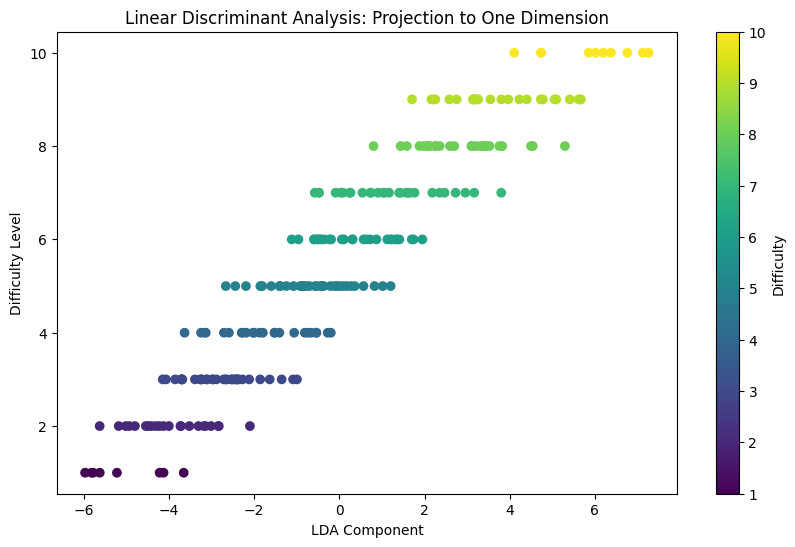

In [ ]:
X = df[featureList]
y = df[targetFeature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y_encoded)

df['LDA_Component'] = X_lda.squeeze()

X_lda = df['LDA_Component']
y_lda = df[targetFeature]

plt.figure(figsize=(10, 6))
plt.scatter(X_lda, y_lda, c=y.Difficulty, cmap='viridis')
plt.xlabel('LDA Component')
plt.ylabel('Difficulty Level')
plt.title('Linear Discriminant Analysis: Projection to One Dimension')
plt.colorbar(label='Difficulty')
plt.show()


In [ ]:
feature_weighting = pd.DataFrame(lda.coef_, columns=X.columns, index=sorted(y.Difficulty.unique()))
feature_weighting['MaxInfluence'] = feature_weighting[X.columns].apply(max_abs_column_name, axis=1)
feature_weighting['MinInfluence'] = feature_weighting[X.columns].apply(min_abs_column_name, axis=1)

feature_weighting

NoteDensity  AverageTimeDifference  LongestHighDensitySequence  \
1     -1.016289              11.634746                    0.017177   
2     -3.855977               4.424541                   -0.417057   
3     -5.427641              -0.877173                   -0.262211   
4     -5.184972              -2.839148                   -0.215200   
5     -3.201797              -3.239731                   -0.112445   
6     -0.646109              -2.376118                   -0.001524   
7      1.638745              -1.785730                   -0.073168   
8      5.317967               0.426716                    0.422105   
9      7.190487               1.816681                    0.161498   
10    13.852302               7.092949                    1.263975   

    HighNoteDensity2s           MaxInfluence                MinInfluence  
1           -3.612693  AverageTimeDifference  LongestHighDensitySequence  
2           -3.887464  AverageTimeDifference  LongestHighDensitySequence  
3           -3.737597            NoteDensity  LongestHighDensitySequence  
4           -2.727902            NoteDensity  LongestHighDensitySequence  
5           -1.695927  AverageTimeDifference  LongestHighDensitySequence  
6           -0.411708  AverageTimeDifference  LongestHighDensitySequence  
7            0.483994  AverageTimeDifference  LongestHighDensitySequence  
8            3.585439            NoteDensity  LongestHighDensitySequence  
9            5.968914            NoteDensity  LongestHighDensitySequence  
10          10.159364            NoteDensity  LongestHighDensitySequence

# Model

In [ ]:
featureList

['NoteDensity', 'AverageTimeDifference', 'HighNoteDensity2s']

## Curr. SVR

In [ ]:
featureList = ["BPM", 'NoteDensity', 'HighNoteDensity2s']

X = df[featureList].values
y = df[targetFeature]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train, X_test, y_train, y_test = X, X, y, y # cross validation is sufficient here

param_grid = {'C': np.linspace(0.01, 100, num=1000)}

# # params by PKBeam
# svm = SVR(epsilon=0.5, C=33.74)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GridSearchCV(estimator=SVR(epsilon=0.5), param_grid=param_grid, cv=5))
])

pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=5, estimator=SVR(epsilon=0.5),
                              param_grid={'C': array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02])}))])

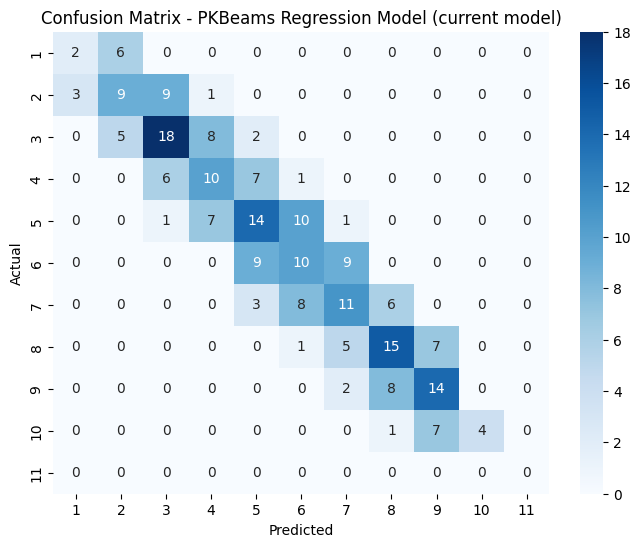

Accuracy     0.445833
Precision    0.463895
Recall       0.445833
F1           0.445295
MCC          0.374955
dtype: float64

In [ ]:
X_test, y_test = X, y
y_linear = pipeline.predict(X_test)

y_pred = []
for prob in y_linear:
    binary_prediction = int(prob + 0.5)
    y_pred.append(binary_prediction)

# classes = np.sort(y.Difficulty.unique())
classes = range(1, 12)
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=classes)
plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix - PKBeams Regression Model (current model)', cmap=plt.cm.Blues)

pd.Series({
    "Accuracy": metrics.accuracy_score(y_test, y_pred),
    "Precision": metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0),
    "Recall": metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0),
    "F1": metrics.f1_score(y_test, y_pred, average='weighted'),
    "MCC": metrics.matthews_corrcoef(y_test, y_pred)
})

## LDA 4Dim, SVR

In [ ]:
featureList = ["NoteDensity", "AverageTimeDifference", "LongestHighDensitySequenceLen", "HighNoteDensity2s"]

X = df[featureList].values
y = df[targetFeature].values.ravel()

param_grid = {'C': np.logspace(-2, 2, num=1000)}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('lda', LDA(n_components=4)),
    ('pca', PCA(n_components=4)),
    ('classifier', GridSearchCV(estimator=SVR(epsilon=0.5), param_grid=param_grid, cv=10))
], verbose=True)

pipeline.fit(X, y)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  40.8s


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=4)),
                ('classifier',
                 GridSearchCV(cv=10, estimator=SVR(epsilon=0.5),
                              param_grid={'C': array([1.00000000e-02, 1.00926219e-02, 1.01861017e-02, 1.02804473e-02,
       1.03756668e-02, 1.04717682e-02, 1.05687597e-02, 1.06666496e-02,
       1.07654461e-02, 1.08651577e-02, 1.09657929e-02, 1.10673602e-02,
       1.11698682e-02,...
       8.08924349e+01, 8.16416760e+01, 8.23978568e+01, 8.31610415e+01,
       8.39312950e+01, 8.47086827e+01, 8.54932707e+01, 8.62851257e+01,
       8.70843150e+01, 8.78909065e+01, 8.87049689e+01, 8.95265713e+01,
       9.03557835e+01, 9.11926760e+01, 9.20373200e+01, 9.28897872e+01,
       9.37501502e+01, 9.46184819e+01, 9.54948564e+01, 9.63793480e+01,
       9.72720319e+01, 9.81729841e+01, 9.90822810e+01, 1.00000000e+02])}))],
         verbose=True)

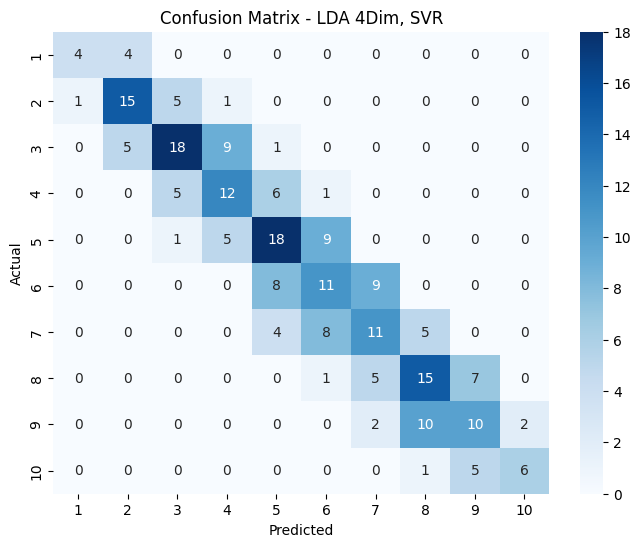

Accuracy     0.500000
Precision    0.510354
Recall       0.500000
F1           0.501627
MCC          0.436976
dtype: float64

In [ ]:
X_test, y_test = X, y
y_linear = pipeline.predict(X_test)

y_pred = []
for prob in y_linear:
    binary_prediction = int(prob + 0.5)
    y_pred.append(binary_prediction)

# classes = np.sort(y.Difficulty.unique())
classes = range(1, 11)
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=classes)
plot_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion Matrix - LDA 4Dim, SVR', cmap=plt.cm.Blues)

pd.Series({
    "Accuracy": metrics.accuracy_score(y_test, y_pred),
    "Precision": metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0),
    "Recall": metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0),
    "F1": metrics.f1_score(y_test, y_pred, average='weighted'),
    "MCC": metrics.matthews_corrcoef(y_test, y_pred)
})

# Export

In [ ]:
from sklearn2pmml import PMMLPipeline, sklearn2pmml

pmml_pipeline = PMMLPipeline(pipeline.steps)
pmml_pipeline.fit(X, y)

print(pmml_pipeline)

sklearn2pmml(pmml_pipeline, "model.pmml")

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

input_type = [('input', FloatTensorType([None, len(featureList)]))]

onnx_model = convert_sklearn(pipeline, 'model.onnx', initial_types=input_type)

with open("./model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

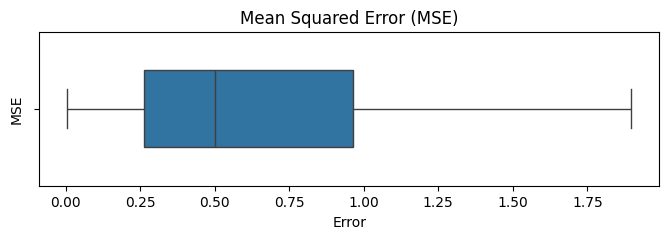

actual  predicted     error
198       3   4.896520  1.896520
28        5   3.120402  1.879598
56        9   7.159472  1.840528
49        7   5.177969  1.822031
5         8   6.219867  1.780133
..      ...        ...       ...
126       3   2.983205  0.016795
195       1   1.015640  0.015640
159       4   3.985873  0.014127
166       6   5.987521  0.012479
108       2   1.993605  0.006395

[240 rows x 3 columns]

In [ ]:
#test model
import onnxruntime as rt
sess = rt.InferenceSession("./model.onnx")
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
pred_onx = sess.run([output_name], {input_name: X.astype(np.float32)})[0]

predicted_labels = [float(label) for label in pred_onx]
errors = np.abs(y_test - predicted_labels)
df_model_result = pd.DataFrame({"actual": y_test, "predicted": predicted_labels, "error": errors})
df_model_result = df_model_result.sort_values(by="error", ascending=False)

plt.figure(figsize=(8, 2))
sns.boxplot(x='error', data=df_model_result, width=0.5)
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Error')
plt.ylabel('MSE')
plt.show()

df_model_result

In [ ]:
df[featureList].min()

NoteDensity                      1.627074
AverageTimeDifference            0.152743
HighNoteDensity2s                2.181818
LongestHighDensitySequenceLen    0.000000
dtype: float64

In [ ]:
df[featureList].max()